In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from tqdm.notebook import tqdm, trange

In [2]:
%load_ext autoreload
%autoreload 2

from bs_transfer import *
from bs_net import *
from bs_gameclass import *
from bs_helpers import *
from bs_selfplay import *

## Training

In [3]:

# Batch generator for neural network training


def batchgen(gamerecords, size=50, istart=0, iend=0, augment=True, verbose=None):
    '''size: minibatchsize
    istart, iend: Start- und Endindex der herausgegebenen Samples
    verbose: Wenn überschrieben, dann mit einem String des Batchgen Namens (z. B. Supervised)'''
    ep = 0
    if not iend: iend = len(gamerecords)
    while True:
        ilist = range(istart, iend)
        ilist = np.random.permutation(ilist)
        minibatches = [ ilist[k*size:(k+1)*size] for k in range(len(ilist)//size) ]
        for mb in minibatches:
            xs = np.zeros((size, SX, SY, 3))
            ps = np.zeros((size, SX, SY, 1))
            vs = np.zeros((size, 1))
            for i, k in enumerate(mb):
                s, a, r = gamerecords[k]
                
                '''
                if np.random.rand()<.5:
                    s = GameIsola.mirrorx_state(s)
                    adist = mirrorx_dist(adist)
                if np.random.rand()<.5:
                    s = GameIsola.mirrory_state(s)
                    adist = mirrorx_dist(adist)'''
                    
                xs[i] = encode_x(s.sea, s.det)
                ps[i, a] = 1.
                vs[i] = r
                    
            yield xs, ps, vs
        if verbose:
            print(f'{verbose}: finished one epoch ({ep})!')
        ep += 1
         
        
        
        

def train(net, gamerecords, gamerecords_legacy=None, iterations=4000, verbose=0):
    '''Trainiert das Netz'''

    try: net.optimizer
    except:
        net.optimizer = torch.optim.Adam(lr=3e-4, params=net.parameters(), weight_decay=0e-4)
    optimizer = net.optimizer
    bg_v = batchgen(gamerecords, iend=500, size=500)
    bg_s = batchgen(gamerecords, istart=500, size=200, verbose='supervised')
    #bg_u = batchgen(gamerecords_legacy, size=400)
    celoss = nn.CrossEntropyLoss()
    MSE = nn.MSELoss()
    L1Loss = nn.L1Loss()
    LogLoss = lambda yp, yt: torch.mean(torch.sum(-yt*torch.log(yp+1e-12), dim=1))
    losses1 = []
    losses2 = []
    ###semlosses = []
    ###mtlosses = []


    def valloss():
        x, tp, tv = next(bg_v)
        x, tp, tv = np2t(x, tp, tv)
        pp, pv = net(x)

        loss1 = LogLoss(pp, tp)
        loss2 = MSE(pv[:,0], tv[:,0])
        return loss1.item(), loss2.item()

    
    for k in trange(iterations):
        x, tp, tv = next(bg_s)
        x, tp, tv = np2t(x, tp, tv)
        pp, pv = net(x)
        #tp = tp.type(torch.long)

        loss1 = LogLoss(pp, tp)
        loss2 = MSE(pv[:,0], tv[:,0])
        loss = loss1 + loss2
        loss.backward()

        # do the training step on the network
        optimizer.step()
        optimizer.zero_grad()

        # Statistic
        losses1 += [loss1.item()]
        losses2 += [loss2.item()]

        # Verbose output, measure minimum val loss
        if len(losses1) == 100:
            vloss1, vloss2 = valloss()
            if verbose>=1:
                print('Loss1=%f, Loss12=%f, ValLoss1=%f, ValLoss2=%f'% (np.mean(losses1), np.mean(losses2), vloss1, vloss2))
            losses1, losses2 = [], []
            
    return net

In [128]:
#newgames = selfplay(MultiMCTS(nparallel=1, nsearches=50, net=net), ngames=200, verbose=1)  # 25 min für 200 games!
#newgames = selfplay(MultiMCTS(nparallel=10, nsearches=50, net=net), ngames=200, verbose=1)  #  5 min für 200 games! batching verschlechtert spielperformance ein wenig!
#newgames = selfplay_batched(BatchMCTS(nparallel=20, nsearches=50, net=net), ngames=200, verbose=1) # 3 min für 200 games!

In [4]:
from isola_net import NetAdaptive as Net

net = Net()
frame = 1
game_rec = []
winrates = []
mmdepths=[]
depthminimax = 2
stage = 0

print(f'Game record has length {len(game_rec)}')

Game record has length 0


In [5]:


depthminimax = 3
frame = 1
stage = 1

while True:

    
    # Evaluate/Pit
    if stage==0:
        print('Pitting')
        winrate = pit(MultiMCTS(nparallel=1, nsearches=100, net=net), MiniMax(maxdepth=depthminimax), n=20, nrnd=2, frame=frame, verbose=1)
        print(winrate)
        winrates.append(winrate)
        mmdepths.append(depthminimax)
        plt.plot(winrates, 'C2')
        plt.plot(np.array(mmdepths)/10, 'C0o-', lw=0.5)
        plt.show()
        if winrate>=1.0 and depthminimax<2:
            depthminimax += 1
            print(f'Changing minimax depth to {depthminimax}')
        stage = 1
    
    
    # Selfplay
    if stage==1:
        print('Selfplay')
        #newgames = selfplay(MultiMCTS(nparallel=5, nsearches=50, net=net), ngames=200, verbose=1)
        newgames = selfplay_batched(BatchMCTS(nparallel=15, nsearches=500, net=net, params={'useQ':True,'cpuct':0.2}), ngames=50, verbose=1) #50
        newgames += load_selfplay()
        game_rec = newgames + game_rec
        print('number of new states:', len(newgames))
        print('size of game rec:', len(game_rec))
        stage=2
    
    # Train
    if stage==2:
        print('Training')          #30000
        net = train(net, game_rec[:5000], game_rec[150000:400000], iterations=50, verbose=1)
        w = pit(MultiMCTS(nparallel=10, nsearches=100, net=net), \
                MultiMCTS(nparallel=10, nsearches=100, net=Net('net_temp.dat')), n=50, nrnd=2, frame=frame, verbose=0)
        print('Winrate of new network: ', w)
        if w > 0.55:
            torch.save(net.state_dict(), 'net_temp.dat')
            print('<=== SAVING NETWORK ===>')
        stage = 0
    

Selfplay


NameError: name 'BatchMCTS' is not defined

In [8]:
len(game_rec)

47012

In [23]:

net = train(net, game_rec[:3000], game_rec[150000:400000], iterations=1000, verbose=1)
w = pit(MultiMCTS(nparallel=1, nsearches=1, net=net), \
        MultiMCTS(nparallel=1, nsearches=1, net=Net('net_temp.dat')), n=100, nrnd=1, frame=frame, verbose=0)
print('Winrate of new network: ', w)
if w > 0.55:
    torch.save(net.state_dict(), 'net_temp.dat')

  0%|          | 0/1000 [00:00<?, ?it/s]

supervised: finished one epoch (0)!


KeyboardInterrupt: 

In [230]:
pit(MultiMCTS(nparallel=50, nsearches=1, net=net), MultiMCTS(nparallel=50, nsearches=1, net=Net('net_temp.dat')), n=100, nrnd=1, frame=frame, verbose=0)

Warning! Performing at least 50 rollouts since nparallel is this value!
Warning! Performing at least 50 rollouts since nparallel is this value!


0.49

In [6]:
net = NetAdaptive('net_depth3.dat')

In [40]:
net = NetAdaptive()

In [131]:
with open('data/selfplay_unet.dat', 'rb') as f:
    game_rec = pkl.load(f)

In [7]:
while True:
    net = train(net, game_rec[:], game_rec[100000:], iterations=300, verbose=1)
    torch.save(net.state_dict(), 'net_temp.dat')

  0%|          | 0/300 [00:00<?, ?it/s]

Loss1=9.685635, Loss12=0.313692, ValLoss1=10.365581, ValLoss2=0.130258
Loss1=9.625525, Loss12=0.295609, ValLoss1=10.146382, ValLoss2=0.147009
supervised: finished one epoch (0)!
Loss1=9.589412, Loss12=0.278828, ValLoss1=10.264499, ValLoss2=0.156977


  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [39]:
net2 = net

In [67]:
ai1 = MultiMCTS(net, nparallel=15, nsearches=100, params={'useQ':True, 'cpuct': 1})
ai2 = MultiMCTS(net, nparallel=15, nsearches=100, params={'useQ':False, 'cpuct': 4})

pit(ai1, ai2, n=20, nrnd=2, verbose=1)

0 1
1 2
2 3
2 4
3 5
3 6
4 7
4 8
5 9
6 10
7 11
7 12
8 13
8 14
8 15
9 16
10 17
10 18
11 19
11 20


0.55

In [84]:


with open('selfplay_depth3.dat', 'rb') as f:
    gamerecords = pkl.load(f)
    gamerecords_legacy = gamerecords

s, a, r = gamerecords[1]
if s.turn<0:
    s = GameIsola.exchangePlayers(s)
    r *= -1
print_state(s)
print(a, r)

size=50
i = 0

xs = np.zeros((size, 4, boardsize[0], boardsize[1]))
vds = np.zeros((size, GameIsola.numActions))
y1s = np.zeros(size, dtype=int)
y2s = np.zeros((size, 1))

xs[i], vds[i] = net.preprocess(s, GameIsola.getValidActions(s))
y1s[i] = a
y2s[i] = r

~ ~ ~ r ~ ~ 
~ ~ ~ ~ ~ ~ 
~ b ~ ~ ~ ~ 
~ ~ ~ ~ ~ ~ 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 1


ValueError: setting an array element with a sequence.

In [12]:



def batchgen(gamerecords, size=50, istart=0, iend=0, augment=True, verbose=None):
    '''size: minibatchsize
    istart, iend: Start- und Endindex der herausgegebenen Samples
    verbose: Wenn überschrieben, dann mit einem String des Batchgen Namens (z. B. Supervised)'''
    ep = 0
    if not iend: iend = len(gamerecords)
    while True:
        ilist = range(istart, iend)
        ilist = np.random.permutation(ilist)
        minibatches = [ ilist[k*size:(k+1)*size] for k in range(len(ilist)//size) ]
        for mb in minibatches:
            xs = np.zeros((size, SX, SY, 3))
            ps = np.zeros((size, SX, SY, 1))
            vs = np.zeros((size, 1))
            for i, k in enumerate(mb):
                s, a, r = gamerecords[k]
                
                '''
                if np.random.rand()<.5:
                    s = GameIsola.mirrorx_state(s)
                    adist = mirrorx_dist(adist)
                if np.random.rand()<.5:
                    s = GameIsola.mirrory_state(s)
                    adist = mirrorx_dist(adist)'''
                    
                xs[i] = encode_x(s.sea, s.det)
                ps[i, a] = 1.
                vs[i] = r
                    
            yield xs, ps, vs
        if verbose:
            print(f'{verbose}: finished one epoch ({ep})!')
        ep += 1
        

In [13]:
bg = batchgen(gamerecords)
next(bg)

(array([[[[0., 1., 0.],
          [0., 1., 0.],
          [1., 0., 0.],
          ...,
          [0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.]],
 
         [[0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.],
          ...,
          [0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.]],
 
         [[0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.],
          ...,
          [0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.]],
 
         ...,
 
         [[1., 0., 0.],
          [1., 0., 0.],
          [0., 1., 0.],
          ...,
          [0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.]],
 
         [[0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.],
          ...,
          [1., 0., 0.],
          [1., 0., 0.],
          [0., 1., 0.]],
 
         [[1., 0., 0.],
          [0., 1., 0.],
          [0., 1., 0.],
          ...,
          [0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.]]],
 
 
        [

In [78]:
len(gamerecords)

6

In [5]:
# Netzwerk trainieren

with open('data/selfplay_unet.dat', 'rb') as f:
    gamerecords = pkl.load(f)
    game_rec = gamerecords

In [18]:
net = NetAdaptive()

In [78]:
try: net.optimizer
except:
    net.optimizer = torch.optim.Adam(lr=3e-4, params=net.parameters(), weight_decay=1e-4)
optimizer = net.optimizer
bg_v = batchgen(gamerecords, iend=500, size=500)
bg_s = batchgen(gamerecords, istart=500, size=200, verbose='supervised')
bg_u = batchgen(gamerecords_legacy, size=400)
#celoss = nn.CrossEntropyLoss()
#celoss = lambda pp, tp: nn.functional.nll_loss(-torch.log(pp+1e-12)**2, tp)
MSE = nn.MSELoss()
L1Loss = nn.L1Loss()
LogLoss = lambda yp, yt: torch.mean(torch.sum(-yt*torch.log(yp+1e-12), dim=1))
losses1 = []
losses2 = []
    

def valloss():
    b, vds, tp, tv = next(bg_v)
    b, vds, tp, tv = batch2torch(b, vds, tp, tv)
    pp, pv = net(b, vds)
    tp = tp.type(torch.long)

    loss1 = LogLoss(pp, tp)
    loss2 = MSE(pv[:,0], tv[:,0])
    return loss1.item(), loss2.item()


iterations = 10000000
for k in trange(iterations):
    b, vds, tp, tv = next(bg_s)
    b, vds, tp, tv = batch2torch(b, vds, tp, tv)
    pp, pv = net(b, vds)
    tp = tp.type(torch.long)

    loss1 = LogLoss(pp, tp)
    loss2 = MSE(pv[:,0], tv[:,0])
    loss = loss1 + loss2
    loss.backward()

    # do the training step on the network
    optimizer.step()
    optimizer.zero_grad()

    # Statistic
    losses1 += [loss1.item()]
    losses2 += [loss2.item()]

    # Verbose output, measure minimum val loss
    if len(losses1) == 100:
        vloss1, vloss2 = valloss()
        if 2>=1:
            print('Loss1=%f, Loss12=%f, ValLoss1=%f, ValLoss2=%f'% (np.mean(losses1), np.mean(losses2), vloss1, vloss2))
        losses1, losses2 = [], []
    if k%1000 == 0:
        pit(MultiMCTS(nparallel=10, nsearches=100, net=net), MiniMax(maxdepth=3), n=20, nrnd=2, frame=frame, verbose=1)



  0%|          | 0/10000000 [00:00<?, ?it/s]

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
Loss1=13.960388, Loss12=0.996118, ValLoss1=13.361937, ValLoss2=0.992096
Loss1=14.130828, Loss12=0.984971, ValLoss1=12.208862, ValLoss2=0.971813
Loss1=14.005686, Loss12=0.963207, ValLoss1=13.817179, ValLoss2=0.938954
Loss1=14.081721, Loss12=0.845104, ValLoss1=14.067407, ValLoss2=0.722690
Loss1=13.993216, Loss12=0.690289, ValLoss1=13.523207, ValLoss2=0.657920
Loss1=13.942542, Loss12=0.617258, ValLoss1=14.078746, ValLoss2=0.641271
Loss1=13.865055, Loss12=0.562019, ValLoss1=13.153264, ValLoss2=0.597267
Loss1=13.998991, Loss12=0.542928, ValLoss1=13.613127, ValLoss2=0.591780
Loss1=13.817384, Loss12=0.517102, ValLoss1=13.422512, ValLoss2=0.568232
Loss1=13.900682, Loss12=0.508616, ValLoss1=13.625265, ValLoss2=0.662962
0 1
0 2
1 3
2 4
3 5
3 6
4 7
4 8
5 9
5 10
6 11
6 12
6 13
6 14
7 15
8 16
9 17
10 18
11 19
11 20
Loss1=13.927172, Loss12=0.485401, ValLoss1=14.458287, ValLoss2=0.529289
supervised: finished on

KeyboardInterrupt: 

In [ ]:

b, vds, tp, tv = next(bg_v)
b, vds, tp, tv = batch2torch(b, vds, tp, tv)
pp, pv = net(b, vds)
tp = tp.type(torch.long)

i = 4
#t2np(pp[i])
plt.plot(t2np(pp[i]))
print(pp[i, tp[i]])


b, r = projectprobabilites(t2np(pp[i]))

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.matshow(b)
ax2.matshow(r)
plt.show()

In [ ]:
t2np(pp[i])

In [12]:
pp

RuntimeError: cuda runtime error (710) : device-side assert triggered at ..\aten\src\THC\THCCachingHostAllocator.cpp:278

In [15]:
frame = 1

In [22]:
pit(MultiMCTS(nparallel=10, nsearches=100, net=net), MiniMax(maxdepth=2), n=20, nrnd=2, frame=frame, verbose=1)

1 1
2 2
3 3
3 4
4 5
5 6
6 7
6 8
7 9
7 10
8 11
9 12
9 13
9 14
10 15
10 16
10 17
10 18
10 19
10 20


0.5

In [ ]:
# Dateien zusammenfügen

In [6]:
gamerecords = []
for i in range(10000):
    with open('temp/selfplay%d.dat' % i, 'rb') as f:
        gamerecords += pkl.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'temp/selfplay563.dat'

In [7]:
with open('selfplay_mcts1.dat', 'wb') as f:
    pkl.dump(gamerecords, f)

In [89]:
torch.save(net.state_dict(), 'net_temp.dat')

In [ ]:
pit(MultiMCTS(nparallel=10, nsearches=100, net=Net()), MiniMax(maxdepth=depthminimax), n=20, nrnd=2, frame=frame, verbose=1)

In [39]:

pit(MultiMCTS(nparallel=10, nsearches=100, net=net), \
    MultiMCTS(nparallel=10, nsearches=100, net=Net('net_temp.dat')), n=20, nrnd=2, frame=frame, verbose=0)

0.25

In [31]:

pit(MultiMCTS(nparallel=10, nsearches=300, net=net, params={'cpuct': .2}),
    MiniMax(maxdepth=2), n=20, nrnd=2, frame=frame, verbose=1)

1 1
1 2
2 3
3 4
4 5
4 6
5 7
5 8
6 9
6 10
7 11
8 12
9 13
9 14
10 15
10 16
11 17
11 18
12 19
12 20


0.6

In [ ]:
# Geschwindigkeit des Netzwerks messen

In [33]:
net = NetAdaptive()

In [ ]:
bg_v = batchgen(gamerecords, iend=500)

In [35]:
%%time
for _ in range(100):
    b, vds, tp, tv = next(bg_v)
    b, vds, tp, tv = batch2torch(b, vds, tp, tv)
    #with torch.no_grad():
    pp, pv = net(b, vds)

Wall time: 604 ms


In [ ]:
# gamerecords konvertieren zur version mit distribution für a

In [51]:
newgamerecords = []
for s, a, r in gamerecords:
    dist = np.zeros(GameIsola.numActions)
    dist[a] = 1.
    newgamerecords.append((s, dist, r))

In [52]:
with open('selfplay_depth3.dat', 'wb') as f:
    pkl.dump(newgamerecords, f)

In [26]:
# Design of experiment
#ns = [100, 200, 400, 600, 800, 1200, 1600, 2400, 2800, 3200, 4000, 4800, 10000]
ns = [50, 100, 200, 400, 600]
cpucts = [4, 1, 0.2, 0.1]
useQs = [False, True]
ws = dict()

for i, n in enumerate(ns):
    for j, cpuct in enumerate(cpucts):
        for k, useQ in enumerate(useQs):
            winrate = pit(MultiMCTS(nparallel=20, nsearches=n, net=net, params={'cpuct': cpuct, 'useQ': useQ}),
                          MiniMax(maxdepth=depthminimax), n=20, nrnd=2, frame=frame, verbose=1)
            ws[i, j, k] = winrate
            print(ws)

1 1
1 2
1 3
1 4
1 5
2 6
3 7
3 8
4 9
4 10
4 11
4 12
5 13
5 14
5 15
5 16
6 17
6 18
7 19
7 20
{(0, 0, 0): 0.35}
1 1
2 2
2 3
2 4
3 5
3 6
4 7
4 8
4 9
4 10
4 11
5 12
5 13
5 14
6 15
6 16
7 17
7 18
8 19
8 20
{(0, 0, 0): 0.35, (0, 0, 1): 0.4}
0 1
1 2
1 3
1 4
2 5
2 6
3 7
4 8
4 9
4 10
5 11
5 12
6 13
6 14
7 15
7 16
7 17
7 18
8 19
8 20
{(0, 0, 0): 0.35, (0, 0, 1): 0.4, (0, 1, 0): 0.4}
1 1
1 2
2 3
2 4
3 5
3 6
4 7
4 8
4 9
4 10
4 11
4 12
5 13
5 14
6 15
6 16
7 17
8 18
9 19
10 20
{(0, 0, 0): 0.35, (0, 0, 1): 0.4, (0, 1, 0): 0.4, (0, 1, 1): 0.5}
1 1
1 2
2 3
2 4
2 5
3 6
4 7
4 8
5 9
5 10
5 11
5 12
6 13
6 14
6 15
6 16
7 17
8 18
8 19
8 20
{(0, 0, 0): 0.35, (0, 0, 1): 0.4, (0, 1, 0): 0.4, (0, 1, 1): 0.5, (0, 2, 0): 0.4}
1 1
1 2
2 3
2 4
3 5
4 6
5 7
6 8
7 9
7 10
8 11
9 12
10 13
10 14
11 15
12 16
13 17
14 18
15 19
15 20
{(0, 0, 0): 0.35, (0, 0, 1): 0.4, (0, 1, 0): 0.4, (0, 1, 1): 0.5, (0, 2, 0): 0.4, (0, 2, 1): 0.75}
1 1
1 2
2 3
2 4
3 5
3 6
3 7
3 8
3 9
3 10
4 11
4 12
4 13
4 14
5 15
5 16
6 17
7 18
7 19
8 20
{(0, 

1 1
2 2
3 3
4 4
5 5
5 6
6 7
7 8
8 9
8 10
9 11
10 12
11 13
11 14
12 15
13 16
14 17
14 18
14 19
15 20
{(0, 0, 0): 0.35, (0, 0, 1): 0.4, (0, 1, 0): 0.4, (0, 1, 1): 0.5, (0, 2, 0): 0.4, (0, 2, 1): 0.75, (1, 0, 0): 0.4, (1, 0, 1): 0.6, (1, 1, 0): 0.5, (1, 1, 1): 0.65, (1, 2, 0): 0.4, (1, 2, 1): 0.45, (2, 0, 0): 0.45, (2, 0, 1): 0.65, (2, 1, 0): 0.45, (2, 1, 1): 0.65, (2, 2, 0): 0.55, (2, 2, 1): 0.65, (3, 0, 0): 0.65, (3, 0, 1): 0.6, (3, 1, 0): 0.5, (3, 1, 1): 0.7, (3, 2, 0): 0.65, (3, 2, 1): 0.75, (4, 0, 0): 0.55, (4, 0, 1): 0.55, (4, 1, 0): 0.75}
1 1
1 2
2 3
3 4
4 5
4 6
4 7
5 8
6 9
6 10
7 11
8 12
9 13
10 14
11 15
12 16
13 17
13 18
14 19
15 20
{(0, 0, 0): 0.35, (0, 0, 1): 0.4, (0, 1, 0): 0.4, (0, 1, 1): 0.5, (0, 2, 0): 0.4, (0, 2, 1): 0.75, (1, 0, 0): 0.4, (1, 0, 1): 0.6, (1, 1, 0): 0.5, (1, 1, 1): 0.65, (1, 2, 0): 0.4, (1, 2, 1): 0.45, (2, 0, 0): 0.45, (2, 0, 1): 0.65, (2, 1, 0): 0.45, (2, 1, 1): 0.65, (2, 2, 0): 0.55, (2, 2, 1): 0.65, (3, 0, 0): 0.65, (3, 0, 1): 0.6, (3, 1, 0): 0.5, (3, 1

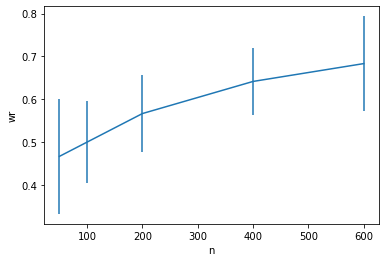

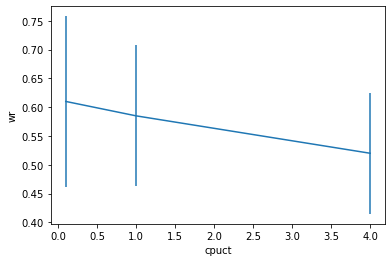

Text(0, 0.5, 'wr')

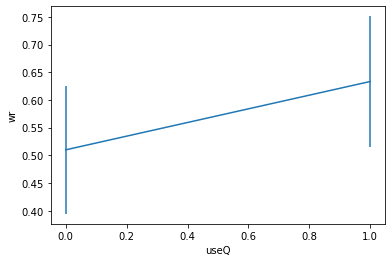

In [34]:
warr = np.zeros((len(ns), len(cpucts), len(useQs)))
for i, j, k in ws.keys():
    warr[i,j,k] = ws[i,j,k]

    
plt.errorbar(ns, warr.mean((1,2)), warr.std((1,2)))
plt.xlabel('n')
plt.ylabel('wr')
plt.show()
    
plt.errorbar(cpucts, warr.mean((0,2)), warr.std((0,2)))
plt.xlabel('cpuct')
plt.ylabel('wr')
plt.show()
    
plt.errorbar([0,1], warr.mean((0,1)), warr.std((0,1)))
plt.xlabel('useQ')
plt.ylabel('wr')

In [47]:
from sklearn import linear_model
md = linear_model.LinearRegression()
md.fit([(n, cpuct, useQ) for n in ns for cpuct in cpucts for useQ in useQs], warr.flatten())
md.coef_

array([ 0.00039223, -0.02272182,  0.12333333])

In [23]:
#  300  0.45
#  800  0.65
# 1200  0.65
# 1600  0.6
# 2400  0.75
# 2800  0.75
# 3200  0.8
# 3600  0.6
# 4000  0.75
# 4400  0.6
# 4800  0.8

winrate = pit(MultiMCTS(nparallel=20, nsearches=4400, net=net), MiniMax(maxdepth=depthminimax), n=20, nrnd=2, frame=frame, verbose=1)
print(winrate)

1 1
2 2
3 3
4 4
5 5
5 6
6 7
6 8
7 9
7 10
7 11
8 12
8 13
9 14
9 15
10 16
10 17
11 18
12 19
12 20
0.6


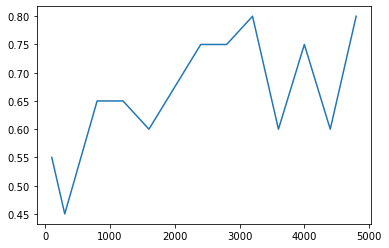

In [24]:
plt.plot([100, 300, 800, 1200, 1600, 2400, 2800, 3200, 3600, 4000, 4400, 4800], [0.55, 0.45, 0.65, 0.65, 0.6, 0.75, 0.75, 0.8, 0.6, 0.75, 0.6, 0.8])

In [32]:
pit(MultiMCTS(nparallel=20, nsearches=300, net=NetAdaptive('net_temp.dat'), params={'useQ':True,'cpuct':0.2}),
    MultiMCTS(nparallel=20, nsearches=300, net=NetAdaptive('net_depth3.dat'), params={'useQ':True,'cpuct':0.2}),
            n=50, nrnd=2, frame=1, verbose=1)

0 1
1 2
2 3
2 4
3 5
3 6
3 7
3 8
4 9
4 10
5 11
5 12
6 13
6 14
7 15
7 16
7 17
8 18
8 19
9 20
9 21
10 22
10 23
11 24
11 25
11 26
11 27
11 28
12 29
13 30
14 31
14 32
15 33
16 34
16 35
17 36
17 37
17 38
18 39
18 40
19 41
19 42
20 43
20 44
21 45
21 46
22 47
22 48
22 49
22 50


0.44

In [9]:
# neu: 0.82
# alt: 0.78

0.8200000000000001

In [47]:
pit(MultiMCTS(nparallel=20, nsearches=300, net=net2, params={'useQ':True,'cpuct':0.2}),
    MultiMCTS(nparallel=20, nsearches=300, net=Net(),  params={'useQ':True,'cpuct':0.2}),
            n=50, nrnd=2, frame=1, verbose=1)

1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9


KeyboardInterrupt: 

In [140]:

# Batch generator for neural network training





def batchgen(gamerecords, size=50, istart=0, iend=0, augment=True, verbose=None):
    '''size: minibatchsize
    istart, iend: Start- und Endindex der herausgegebenen Samples
    verbose: Wenn überschrieben, dann mit einem String des Batchgen Namens (z. B. Supervised)'''
    ep = 0
    if not iend: iend = len(gamerecords)
    while True:
        ilist = range(istart, iend)
        ilist = np.random.permutation(ilist)
        minibatches = [ ilist[k*size:(k+1)*size] for k in range(len(ilist)//size) ]
        for mb in minibatches:
            xs = np.zeros((size, SX, SY, 3))
            ps = np.zeros((size, SX, SY, 1))
            vs = np.zeros((size, 1))
            for i, k in enumerate(mb):
                s, a, r = gamerecords[k]
                s = s.copy()
                
                rnd = np.random.rand
                if rnd()<.5:
                    s = GameClass.mirrorx_state(s)
                    a = GameClass.mirrorx_action(a)
                if rnd()<.5:
                    s = GameClass.mirrory_state(s)
                    a = GameClass.mirrorx_action(a)
                if rnd()<.5:
                    s = GameClass.mirror_transpose_state(s)
                    a = GameClass.mirror_transpose_action(a)
                    
                xs[i] = encode_x(s.sea, s.det)
                ps[i, a] = 1.
                vs[i] = r
                    
            yield xs, ps, vs
        if verbose:
            print(f'{verbose}: finished one epoch ({ep})!')
        ep += 1
         
        
        
        

def train(net, gamerecords, gamerecords_legacy=None, iterations=4000, verbose=0):
    '''Trainiert das Netz'''

    try: net.optimizer
    except:
        net.optimizer = torch.optim.Adam(lr=3e-4, params=net.parameters(), weight_decay=0e-4)
    optimizer = net.optimizer
    bg_v = batchgen(gamerecords, iend=500, size=500)
    bg_s = batchgen(gamerecords, istart=500, size=200, verbose='supervised')
    #bg_u = batchgen(gamerecords_legacy, size=400)
    celoss = nn.CrossEntropyLoss()
    MSE = nn.MSELoss()
    L1Loss = nn.L1Loss()
    LogLoss = lambda yp, yt: torch.mean(torch.sum(-yt*torch.log(yp+1e-12), dim=1))
    losses1 = []
    losses2 = []
    ###semlosses = []
    ###mtlosses = []


    def valloss():
        x, tp, tv = next(bg_v)
        x, tp, tv = np2t(x, tp, tv)
        pp, pv = net(x)

        loss1 = LogLoss(pp, tp)
        loss2 = 10*MSE(pv[:,0], tv[:,0])
        return loss1.item(), loss2.item()

    
    for k in trange(iterations):
        x, tp, tv = next(bg_s)
        x, tp, tv = np2t(x, tp, tv)
        pp, pv = net(x)
        #tp = tp.type(torch.long)

        loss1 = LogLoss(pp, tp)
        loss2 = 10*MSE(pv[:,0], tv[:,0])
        loss = loss1 + loss2
        loss.backward()

        # do the training step on the network
        optimizer.step()
        optimizer.zero_grad()

        # Statistic
        losses1 += [loss1.item()]
        losses2 += [loss2.item()]

        # Verbose output, measure minimum val loss
        if len(losses1) == 100:
            vloss1, vloss2 = valloss()
            if verbose>=1:
                print('Loss1=%f, Loss12=%f, ValLoss1=%f, ValLoss2=%f'% (np.mean(losses1), np.mean(losses2), vloss1, vloss2))
            losses1, losses2 = [], []
            
            
        if k%1000==0:
            inds = np.random.choice(range(len(game_rec)), size=100)
            rt = [ game_rec[i][2] for i in inds ]

            rp = []
            for i in inds:
                s = game_rec[i][0]
                p, v = net(np2t([encode_x(s.sea, s.det)]))
                rp.append(v.item())
            plt.scatter(rt, rp)
            plt.show()
            
    return net

  0%|          | 0/400000 [00:00<?, ?it/s]

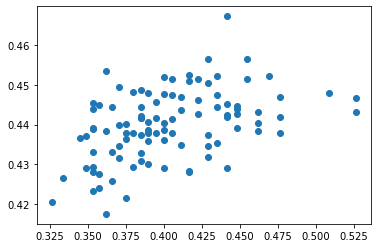

Loss1=8.741074, Loss12=0.008808, ValLoss1=8.805086, ValLoss2=0.013264
Loss1=8.762028, Loss12=0.008737, ValLoss1=8.814296, ValLoss2=0.013513
Loss1=8.773771, Loss12=0.008671, ValLoss1=8.878769, ValLoss2=0.015515
Loss1=8.759264, Loss12=0.008805, ValLoss1=8.823506, ValLoss2=0.013919
Loss1=8.745909, Loss12=0.008909, ValLoss1=8.805085, ValLoss2=0.013533
Loss1=8.756501, Loss12=0.008619, ValLoss1=8.814296, ValLoss2=0.016400
Loss1=8.765711, Loss12=0.008812, ValLoss1=8.777454, ValLoss2=0.012812
Loss1=8.753508, Loss12=0.008349, ValLoss1=8.860348, ValLoss2=0.014259
Loss1=8.762948, Loss12=0.008575, ValLoss1=8.795875, ValLoss2=0.015463
Loss1=8.754428, Loss12=0.008610, ValLoss1=8.676141, ValLoss2=0.015838


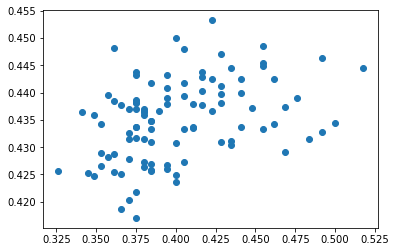

Loss1=8.758343, Loss12=0.008181, ValLoss1=8.786665, ValLoss2=0.013914
Loss1=8.741995, Loss12=0.007803, ValLoss1=8.777454, ValLoss2=0.015763
Loss1=8.755580, Loss12=0.007918, ValLoss1=8.740613, ValLoss2=0.013702
Loss1=8.743146, Loss12=0.008388, ValLoss1=8.795875, ValLoss2=0.014108
Loss1=8.754889, Loss12=0.007882, ValLoss1=8.823506, ValLoss2=0.014956
supervised: finished one epoch (0)!
Loss1=8.746369, Loss12=0.007839, ValLoss1=8.759033, ValLoss2=0.014303
Loss1=8.749363, Loss12=0.007526, ValLoss1=8.777454, ValLoss2=0.012761
Loss1=8.753738, Loss12=0.008440, ValLoss1=8.887979, ValLoss2=0.014694
Loss1=8.738540, Loss12=0.007922, ValLoss1=8.795875, ValLoss2=0.014453
Loss1=8.744988, Loss12=0.007846, ValLoss1=8.777454, ValLoss2=0.016007


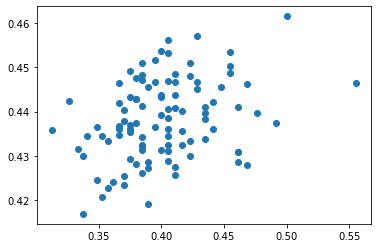

Loss1=8.756270, Loss12=0.007951, ValLoss1=8.749823, ValLoss2=0.016125
Loss1=8.757882, Loss12=0.007380, ValLoss1=8.795875, ValLoss2=0.015288
Loss1=8.743836, Loss12=0.007362, ValLoss1=8.832716, ValLoss2=0.017151
Loss1=8.740383, Loss12=0.007679, ValLoss1=8.851137, ValLoss2=0.014320
Loss1=8.749132, Loss12=0.007149, ValLoss1=8.841928, ValLoss2=0.015702
Loss1=8.757422, Loss12=0.007499, ValLoss1=8.786665, ValLoss2=0.014268
Loss1=8.760185, Loss12=0.007219, ValLoss1=8.934030, ValLoss2=0.013487
Loss1=8.771468, Loss12=0.007349, ValLoss1=8.703772, ValLoss2=0.013889
Loss1=8.770546, Loss12=0.007422, ValLoss1=8.795875, ValLoss2=0.015544
Loss1=8.765711, Loss12=0.007193, ValLoss1=8.832716, ValLoss2=0.014230


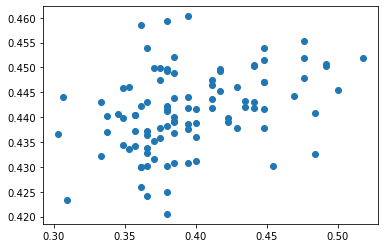

Loss1=8.755349, Loss12=0.007080, ValLoss1=8.768245, ValLoss2=0.016642
supervised: finished one epoch (1)!
Loss1=8.749593, Loss12=0.006869, ValLoss1=8.786665, ValLoss2=0.014296
Loss1=8.735087, Loss12=0.007042, ValLoss1=8.786665, ValLoss2=0.015382
Loss1=8.745679, Loss12=0.007039, ValLoss1=8.795877, ValLoss2=0.015879
Loss1=8.765021, Loss12=0.006947, ValLoss1=8.860349, ValLoss2=0.015216
Loss1=8.761336, Loss12=0.006665, ValLoss1=8.814296, ValLoss2=0.015242
Loss1=8.762718, Loss12=0.006511, ValLoss1=8.795876, ValLoss2=0.015055
Loss1=8.759495, Loss12=0.006595, ValLoss1=8.768245, ValLoss2=0.014027
Loss1=8.772159, Loss12=0.006487, ValLoss1=8.832717, ValLoss2=0.015744
Loss1=8.753969, Loss12=0.006430, ValLoss1=8.814297, ValLoss2=0.017976


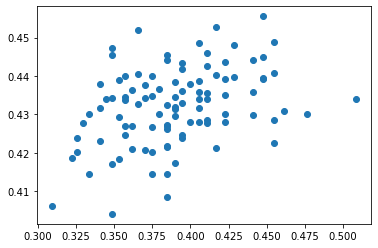

Loss1=8.748902, Loss12=0.006142, ValLoss1=8.832716, ValLoss2=0.014965
Loss1=8.751435, Loss12=0.006398, ValLoss1=8.722192, ValLoss2=0.015729
Loss1=8.767323, Loss12=0.006351, ValLoss1=8.759035, ValLoss2=0.014733
Loss1=8.754198, Loss12=0.006472, ValLoss1=8.731402, ValLoss2=0.014274
Loss1=8.753278, Loss12=0.006418, ValLoss1=8.795877, ValLoss2=0.015626
Loss1=8.761337, Loss12=0.006201, ValLoss1=8.832717, ValLoss2=0.014710
Loss1=8.737620, Loss12=0.006139, ValLoss1=8.814296, ValLoss2=0.014468
supervised: finished one epoch (2)!
Loss1=8.754429, Loss12=0.005992, ValLoss1=8.777454, ValLoss2=0.017419
Loss1=8.750053, Loss12=0.005909, ValLoss1=8.841928, ValLoss2=0.013898
Loss1=8.753968, Loss12=0.005946, ValLoss1=8.860349, ValLoss2=0.014745


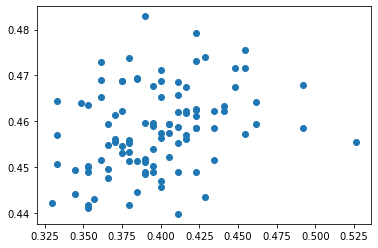

Loss1=8.754429, Loss12=0.006256, ValLoss1=8.814296, ValLoss2=0.015660
Loss1=8.769625, Loss12=0.005857, ValLoss1=8.832717, ValLoss2=0.012972
Loss1=8.739232, Loss12=0.005832, ValLoss1=8.805086, ValLoss2=0.013752
Loss1=8.767094, Loss12=0.005761, ValLoss1=8.759035, ValLoss2=0.012958
Loss1=8.752357, Loss12=0.005996, ValLoss1=8.823507, ValLoss2=0.015814
Loss1=8.738311, Loss12=0.005484, ValLoss1=8.777454, ValLoss2=0.014064
Loss1=8.745449, Loss12=0.005584, ValLoss1=8.786666, ValLoss2=0.017520
Loss1=8.762949, Loss12=0.005955, ValLoss1=8.823507, ValLoss2=0.016197
Loss1=8.762719, Loss12=0.005593, ValLoss1=8.777454, ValLoss2=0.016602
Loss1=8.741765, Loss12=0.005466, ValLoss1=8.823507, ValLoss2=0.015348


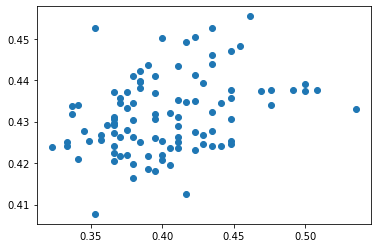

Loss1=8.752127, Loss12=0.005313, ValLoss1=8.832717, ValLoss2=0.015903
Loss1=8.756271, Loss12=0.005451, ValLoss1=8.759035, ValLoss2=0.014750
supervised: finished one epoch (3)!
Loss1=8.767094, Loss12=0.005249, ValLoss1=8.795877, ValLoss2=0.015705
Loss1=8.769396, Loss12=0.005170, ValLoss1=8.759033, ValLoss2=0.015558
Loss1=8.754198, Loss12=0.004952, ValLoss1=8.795875, ValLoss2=0.017073
Loss1=8.745448, Loss12=0.005367, ValLoss1=8.722192, ValLoss2=0.015777
Loss1=8.761797, Loss12=0.005109, ValLoss1=8.869557, ValLoss2=0.015509
Loss1=8.763639, Loss12=0.005233, ValLoss1=8.777454, ValLoss2=0.015914
Loss1=8.744757, Loss12=0.005068, ValLoss1=8.795875, ValLoss2=0.014894
Loss1=8.738540, Loss12=0.005161, ValLoss1=8.777454, ValLoss2=0.016385


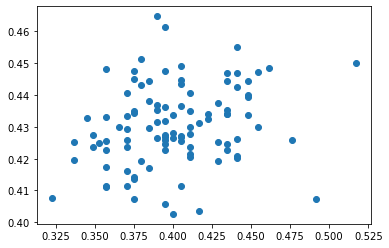

Loss1=8.747060, Loss12=0.004916, ValLoss1=8.869557, ValLoss2=0.017345
Loss1=8.758803, Loss12=0.005042, ValLoss1=8.851136, ValLoss2=0.016867
Loss1=8.751435, Loss12=0.005093, ValLoss1=8.851137, ValLoss2=0.013724
Loss1=8.767783, Loss12=0.004890, ValLoss1=8.814296, ValLoss2=0.013997
Loss1=8.756501, Loss12=0.004937, ValLoss1=8.823507, ValLoss2=0.015111
Loss1=8.765482, Loss12=0.004795, ValLoss1=8.832717, ValLoss2=0.016422
Loss1=8.759495, Loss12=0.005115, ValLoss1=8.814298, ValLoss2=0.015116
Loss1=8.746600, Loss12=0.004670, ValLoss1=8.805085, ValLoss2=0.016581
supervised: finished one epoch (4)!
Loss1=8.717587, Loss12=0.004651, ValLoss1=8.832716, ValLoss2=0.014997
Loss1=8.764099, Loss12=0.004571, ValLoss1=8.814297, ValLoss2=0.016912


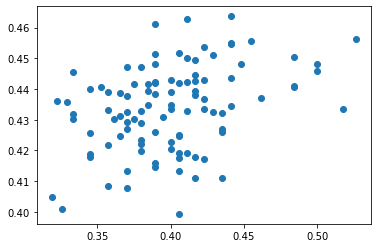

Loss1=8.766862, Loss12=0.004689, ValLoss1=8.777454, ValLoss2=0.014124
Loss1=8.742455, Loss12=0.004880, ValLoss1=8.860349, ValLoss2=0.016917
Loss1=8.752356, Loss12=0.004538, ValLoss1=8.759033, ValLoss2=0.016598
Loss1=8.751896, Loss12=0.004618, ValLoss1=8.676140, ValLoss2=0.016646
Loss1=8.759494, Loss12=0.004699, ValLoss1=8.832716, ValLoss2=0.013696
Loss1=8.764790, Loss12=0.004442, ValLoss1=8.740612, ValLoss2=0.015788
Loss1=8.756040, Loss12=0.004390, ValLoss1=8.740614, ValLoss2=0.015510
Loss1=8.771928, Loss12=0.004405, ValLoss1=8.897188, ValLoss2=0.016355
Loss1=8.757191, Loss12=0.004309, ValLoss1=8.841927, ValLoss2=0.015608
Loss1=8.766862, Loss12=0.004396, ValLoss1=8.795875, ValLoss2=0.017498


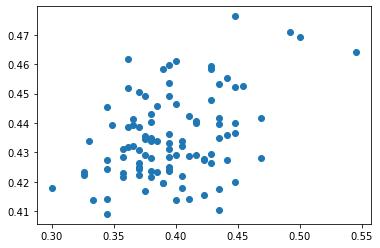

Loss1=8.756501, Loss12=0.004581, ValLoss1=8.768244, ValLoss2=0.017377
Loss1=8.744988, Loss12=0.004393, ValLoss1=8.759033, ValLoss2=0.016146
Loss1=8.758803, Loss12=0.004551, ValLoss1=8.934030, ValLoss2=0.017063
Loss1=8.751666, Loss12=0.004139, ValLoss1=8.786666, ValLoss2=0.015745
supervised: finished one epoch (5)!
Loss1=8.750975, Loss12=0.004187, ValLoss1=8.814296, ValLoss2=0.016314
Loss1=8.744527, Loss12=0.004083, ValLoss1=8.768244, ValLoss2=0.016227
Loss1=8.762718, Loss12=0.004115, ValLoss1=8.795875, ValLoss2=0.017487
Loss1=8.750054, Loss12=0.004054, ValLoss1=8.795875, ValLoss2=0.016395
Loss1=8.763408, Loss12=0.004093, ValLoss1=8.749824, ValLoss2=0.017240
Loss1=8.759034, Loss12=0.004016, ValLoss1=8.860348, ValLoss2=0.017740


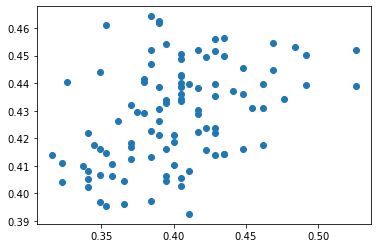

Loss1=8.762718, Loss12=0.004178, ValLoss1=8.814297, ValLoss2=0.015632
Loss1=8.755580, Loss12=0.003978, ValLoss1=8.814296, ValLoss2=0.017080
Loss1=8.753508, Loss12=0.003977, ValLoss1=8.768244, ValLoss2=0.015532
Loss1=8.773770, Loss12=0.003981, ValLoss1=8.841928, ValLoss2=0.015096
Loss1=8.766403, Loss12=0.004082, ValLoss1=8.759035, ValLoss2=0.015282
Loss1=8.758114, Loss12=0.004028, ValLoss1=8.786666, ValLoss2=0.016653
Loss1=8.753048, Loss12=0.003835, ValLoss1=8.832717, ValLoss2=0.015636
Loss1=8.772390, Loss12=0.004163, ValLoss1=8.805086, ValLoss2=0.017498
Loss1=8.744298, Loss12=0.003809, ValLoss1=8.740614, ValLoss2=0.019613
supervised: finished one epoch (6)!
Loss1=8.753508, Loss12=0.003913, ValLoss1=8.814297, ValLoss2=0.017878


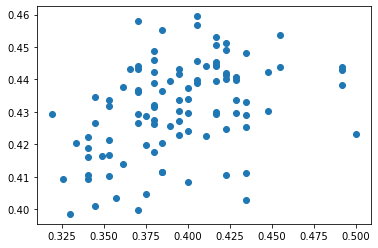

Loss1=8.754890, Loss12=0.003746, ValLoss1=8.777454, ValLoss2=0.017236
Loss1=8.762489, Loss12=0.003794, ValLoss1=8.795877, ValLoss2=0.016904
Loss1=8.758113, Loss12=0.003589, ValLoss1=8.759033, ValLoss2=0.015987
Loss1=8.754428, Loss12=0.003627, ValLoss1=8.805086, ValLoss2=0.015906
Loss1=8.741074, Loss12=0.003651, ValLoss1=8.777455, ValLoss2=0.016533
Loss1=8.751206, Loss12=0.003701, ValLoss1=8.860349, ValLoss2=0.014205
Loss1=8.752357, Loss12=0.003787, ValLoss1=8.786665, ValLoss2=0.016354
Loss1=8.765482, Loss12=0.003719, ValLoss1=8.851138, ValLoss2=0.017389
Loss1=8.759955, Loss12=0.003649, ValLoss1=8.814296, ValLoss2=0.017256
Loss1=8.755349, Loss12=0.003640, ValLoss1=8.786665, ValLoss2=0.016309


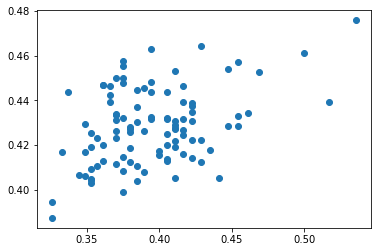

Loss1=8.759955, Loss12=0.003694, ValLoss1=8.823506, ValLoss2=0.015609
Loss1=8.747521, Loss12=0.003931, ValLoss1=8.795875, ValLoss2=0.016290
Loss1=8.754889, Loss12=0.003798, ValLoss1=8.768244, ValLoss2=0.017618
Loss1=8.725186, Loss12=0.003586, ValLoss1=8.777454, ValLoss2=0.016090
Loss1=8.749132, Loss12=0.003578, ValLoss1=8.777454, ValLoss2=0.015691
supervised: finished one epoch (7)!
Loss1=8.758113, Loss12=0.003480, ValLoss1=8.878769, ValLoss2=0.016694
Loss1=8.755119, Loss12=0.003327, ValLoss1=8.823506, ValLoss2=0.017251
Loss1=8.756270, Loss12=0.003443, ValLoss1=8.823506, ValLoss2=0.015393
Loss1=8.759724, Loss12=0.003374, ValLoss1=8.823506, ValLoss2=0.017811
Loss1=8.750514, Loss12=0.003420, ValLoss1=8.786666, ValLoss2=0.017402


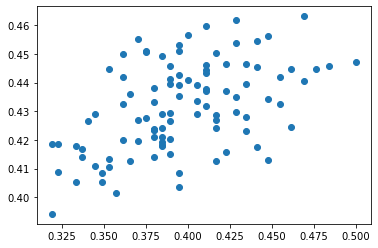

Loss1=8.753738, Loss12=0.003299, ValLoss1=8.869557, ValLoss2=0.017085
Loss1=8.778836, Loss12=0.003498, ValLoss1=8.851137, ValLoss2=0.016153
Loss1=8.763408, Loss12=0.003466, ValLoss1=8.768244, ValLoss2=0.016351
Loss1=8.749593, Loss12=0.003289, ValLoss1=8.814296, ValLoss2=0.016721
Loss1=8.747521, Loss12=0.003241, ValLoss1=8.897188, ValLoss2=0.015909
Loss1=8.755580, Loss12=0.003185, ValLoss1=8.759033, ValLoss2=0.017023
Loss1=8.762257, Loss12=0.003352, ValLoss1=8.777454, ValLoss2=0.017430
Loss1=8.752586, Loss12=0.003478, ValLoss1=8.952451, ValLoss2=0.017079
Loss1=8.753738, Loss12=0.003201, ValLoss1=8.777454, ValLoss2=0.016078
Loss1=8.770086, Loss12=0.003246, ValLoss1=8.823507, ValLoss2=0.018337


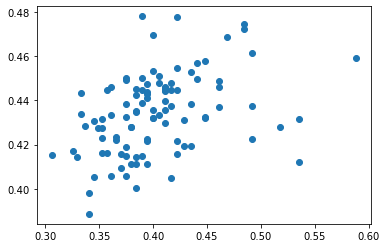

Loss1=8.745219, Loss12=0.003262, ValLoss1=8.823506, ValLoss2=0.018088
supervised: finished one epoch (8)!
Loss1=8.767783, Loss12=0.003176, ValLoss1=8.786665, ValLoss2=0.016037
Loss1=8.762948, Loss12=0.003167, ValLoss1=8.814296, ValLoss2=0.017473
Loss1=8.761106, Loss12=0.003070, ValLoss1=8.841927, ValLoss2=0.016284
Loss1=8.742685, Loss12=0.003053, ValLoss1=8.805085, ValLoss2=0.018152
Loss1=8.755119, Loss12=0.003102, ValLoss1=8.823506, ValLoss2=0.017130
Loss1=8.749363, Loss12=0.003137, ValLoss1=8.795875, ValLoss2=0.016194
Loss1=8.759264, Loss12=0.003224, ValLoss1=8.749824, ValLoss2=0.016566
Loss1=8.773770, Loss12=0.003228, ValLoss1=8.832716, ValLoss2=0.019017
Loss1=8.758343, Loss12=0.002982, ValLoss1=8.860348, ValLoss2=0.017873


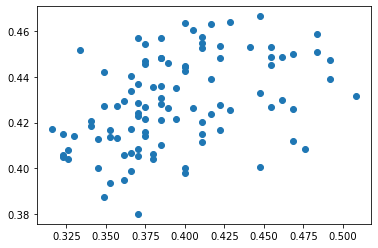

Loss1=8.755580, Loss12=0.003331, ValLoss1=8.887979, ValLoss2=0.018055
Loss1=8.760876, Loss12=0.003200, ValLoss1=8.768244, ValLoss2=0.017650
Loss1=8.743146, Loss12=0.003010, ValLoss1=8.740612, ValLoss2=0.017469
Loss1=8.762718, Loss12=0.003057, ValLoss1=8.851137, ValLoss2=0.017454
Loss1=8.758112, Loss12=0.003011, ValLoss1=8.814296, ValLoss2=0.016419
Loss1=8.766639, Loss12=0.003015, ValLoss1=8.887979, ValLoss2=0.016879
Loss1=8.753738, Loss12=0.003023, ValLoss1=8.814296, ValLoss2=0.017201
supervised: finished one epoch (9)!
Loss1=8.744528, Loss12=0.002949, ValLoss1=8.749825, ValLoss2=0.016287
Loss1=8.739002, Loss12=0.002858, ValLoss1=8.814297, ValLoss2=0.017077
Loss1=8.749364, Loss12=0.003100, ValLoss1=8.823507, ValLoss2=0.018459


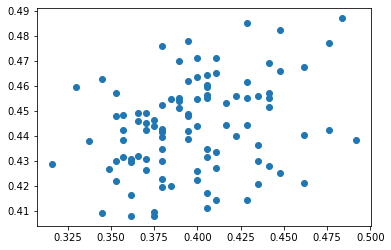

Loss1=8.750976, Loss12=0.002927, ValLoss1=8.805086, ValLoss2=0.017135
Loss1=8.745910, Loss12=0.002901, ValLoss1=8.814296, ValLoss2=0.015516
Loss1=8.767785, Loss12=0.002810, ValLoss1=8.740614, ValLoss2=0.016093
Loss1=8.756272, Loss12=0.002951, ValLoss1=8.777455, ValLoss2=0.015905
Loss1=8.756041, Loss12=0.002834, ValLoss1=8.823507, ValLoss2=0.016047
Loss1=8.757193, Loss12=0.002846, ValLoss1=8.841928, ValLoss2=0.015999
Loss1=8.756732, Loss12=0.002892, ValLoss1=8.832717, ValLoss2=0.017212
Loss1=8.741765, Loss12=0.002872, ValLoss1=8.814298, ValLoss2=0.017414
Loss1=8.766633, Loss12=0.002941, ValLoss1=8.777456, ValLoss2=0.015537
Loss1=8.755120, Loss12=0.002875, ValLoss1=8.759035, ValLoss2=0.015612


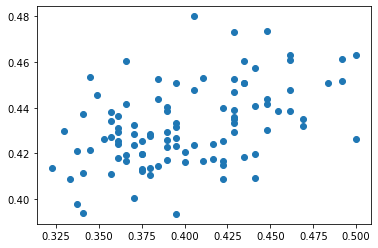

Loss1=8.757423, Loss12=0.002873, ValLoss1=8.749825, ValLoss2=0.014748
Loss1=8.739923, Loss12=0.002915, ValLoss1=8.795877, ValLoss2=0.013844
supervised: finished one epoch (10)!
Loss1=8.745680, Loss12=0.002970, ValLoss1=8.795877, ValLoss2=0.015157
Loss1=8.745910, Loss12=0.002879, ValLoss1=8.878769, ValLoss2=0.017693
Loss1=8.764331, Loss12=0.002779, ValLoss1=8.823507, ValLoss2=0.016631
Loss1=8.762258, Loss12=0.002784, ValLoss1=8.897190, ValLoss2=0.016179
Loss1=8.739693, Loss12=0.002809, ValLoss1=8.814298, ValLoss2=0.016072
Loss1=8.752818, Loss12=0.002723, ValLoss1=8.805086, ValLoss2=0.018435
Loss1=8.763410, Loss12=0.002695, ValLoss1=8.786665, ValLoss2=0.018346
Loss1=8.752127, Loss12=0.002732, ValLoss1=8.795877, ValLoss2=0.016975


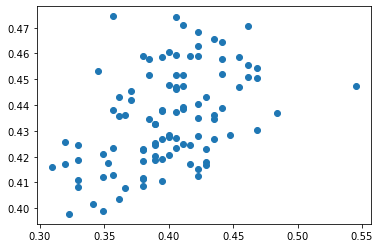

Loss1=8.739233, Loss12=0.002719, ValLoss1=8.786666, ValLoss2=0.015523
Loss1=8.753278, Loss12=0.002596, ValLoss1=8.740614, ValLoss2=0.015181
Loss1=8.762719, Loss12=0.002710, ValLoss1=8.768245, ValLoss2=0.016218
Loss1=8.764791, Loss12=0.002748, ValLoss1=8.814298, ValLoss2=0.015910
Loss1=8.757883, Loss12=0.002659, ValLoss1=8.860349, ValLoss2=0.018418
Loss1=8.736469, Loss12=0.002663, ValLoss1=8.759035, ValLoss2=0.015761
Loss1=8.753969, Loss12=0.002595, ValLoss1=8.851138, ValLoss2=0.015507
Loss1=8.758344, Loss12=0.002637, ValLoss1=8.869558, ValLoss2=0.014729
supervised: finished one epoch (11)!
Loss1=8.766173, Loss12=0.002588, ValLoss1=8.823506, ValLoss2=0.017134
Loss1=8.753278, Loss12=0.002490, ValLoss1=8.759035, ValLoss2=0.016270


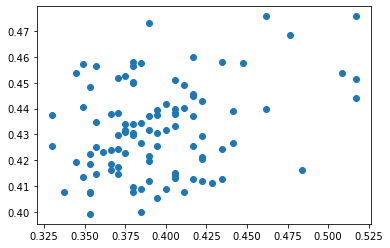

Loss1=8.758344, Loss12=0.002525, ValLoss1=8.740614, ValLoss2=0.014994
Loss1=8.751206, Loss12=0.002539, ValLoss1=8.786665, ValLoss2=0.017475
Loss1=8.749594, Loss12=0.002638, ValLoss1=8.823507, ValLoss2=0.015730
Loss1=8.756731, Loss12=0.002488, ValLoss1=8.777454, ValLoss2=0.015733
Loss1=8.766632, Loss12=0.002505, ValLoss1=8.722192, ValLoss2=0.016201
Loss1=8.747060, Loss12=0.002615, ValLoss1=8.851138, ValLoss2=0.015640
Loss1=8.756962, Loss12=0.002589, ValLoss1=8.777456, ValLoss2=0.015129
Loss1=8.762949, Loss12=0.002547, ValLoss1=8.841928, ValLoss2=0.016105
Loss1=8.757193, Loss12=0.002781, ValLoss1=8.841928, ValLoss2=0.016158
Loss1=8.742686, Loss12=0.002535, ValLoss1=8.795877, ValLoss2=0.015815


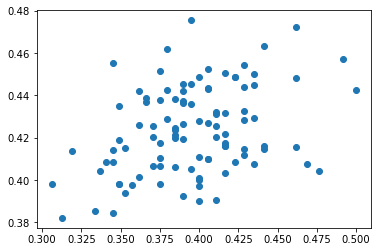

Loss1=8.731864, Loss12=0.002577, ValLoss1=8.777454, ValLoss2=0.014617
Loss1=8.756501, Loss12=0.002518, ValLoss1=8.805086, ValLoss2=0.016479
Loss1=8.766403, Loss12=0.002566, ValLoss1=8.814297, ValLoss2=0.015452
Loss1=8.742456, Loss12=0.002639, ValLoss1=8.814298, ValLoss2=0.016601
supervised: finished one epoch (12)!
Loss1=8.767784, Loss12=0.002529, ValLoss1=8.786664, ValLoss2=0.015939
Loss1=8.742225, Loss12=0.002409, ValLoss1=8.851138, ValLoss2=0.015293
Loss1=8.745910, Loss12=0.002471, ValLoss1=8.795877, ValLoss2=0.015742
Loss1=8.771929, Loss12=0.002536, ValLoss1=8.851138, ValLoss2=0.015804
Loss1=8.765942, Loss12=0.002579, ValLoss1=8.805085, ValLoss2=0.016565
Loss1=8.753968, Loss12=0.002457, ValLoss1=8.759033, ValLoss2=0.015788


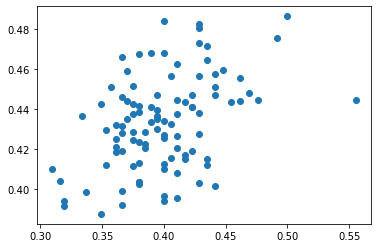

Loss1=8.747981, Loss12=0.002416, ValLoss1=8.795875, ValLoss2=0.014843
Loss1=8.749593, Loss12=0.002424, ValLoss1=8.841927, ValLoss2=0.015858
Loss1=8.762487, Loss12=0.002401, ValLoss1=8.795875, ValLoss2=0.014601
Loss1=8.756731, Loss12=0.002381, ValLoss1=8.860348, ValLoss2=0.017415
Loss1=8.757652, Loss12=0.002382, ValLoss1=8.823506, ValLoss2=0.017005
Loss1=8.742915, Loss12=0.002409, ValLoss1=8.906400, ValLoss2=0.015387
Loss1=8.753047, Loss12=0.002443, ValLoss1=8.777454, ValLoss2=0.016536
Loss1=8.762257, Loss12=0.002380, ValLoss1=8.823506, ValLoss2=0.015902
Loss1=8.767784, Loss12=0.002475, ValLoss1=8.897190, ValLoss2=0.015614
supervised: finished one epoch (13)!
Loss1=8.758573, Loss12=0.002495, ValLoss1=8.841926, ValLoss2=0.016512


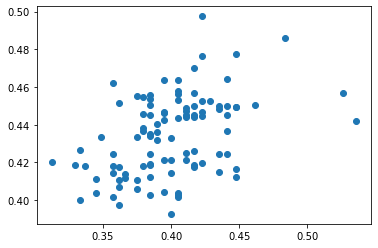

Loss1=8.746369, Loss12=0.002254, ValLoss1=8.786665, ValLoss2=0.015479
Loss1=8.740843, Loss12=0.002348, ValLoss1=8.832716, ValLoss2=0.015435
Loss1=8.733014, Loss12=0.002299, ValLoss1=8.805085, ValLoss2=0.014886
Loss1=8.760876, Loss12=0.002357, ValLoss1=8.878769, ValLoss2=0.015892
Loss1=8.760415, Loss12=0.002328, ValLoss1=8.814296, ValLoss2=0.016635
Loss1=8.767093, Loss12=0.002444, ValLoss1=8.777454, ValLoss2=0.016457
Loss1=8.759724, Loss12=0.002276, ValLoss1=8.805085, ValLoss2=0.017370
Loss1=8.746830, Loss12=0.002319, ValLoss1=8.860348, ValLoss2=0.016484
Loss1=8.763639, Loss12=0.002298, ValLoss1=8.805085, ValLoss2=0.016718
Loss1=8.755810, Loss12=0.002288, ValLoss1=8.768244, ValLoss2=0.015257


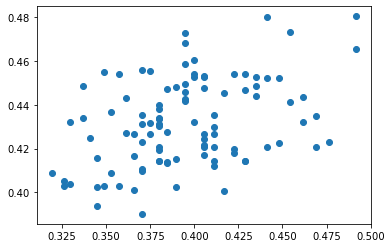

Loss1=8.751896, Loss12=0.002312, ValLoss1=8.749824, ValLoss2=0.014878
Loss1=8.747290, Loss12=0.002299, ValLoss1=8.795875, ValLoss2=0.016361
Loss1=8.728870, Loss12=0.002241, ValLoss1=8.915609, ValLoss2=0.015248
Loss1=8.764790, Loss12=0.002237, ValLoss1=8.786665, ValLoss2=0.016023
Loss1=8.764790, Loss12=0.002336, ValLoss1=8.869558, ValLoss2=0.015908
supervised: finished one epoch (14)!
Loss1=8.761797, Loss12=0.002270, ValLoss1=8.805085, ValLoss2=0.017256
Loss1=8.760185, Loss12=0.002294, ValLoss1=8.832716, ValLoss2=0.016160
Loss1=8.752356, Loss12=0.002144, ValLoss1=8.906399, ValLoss2=0.016762
Loss1=8.748211, Loss12=0.002281, ValLoss1=8.869558, ValLoss2=0.016654
Loss1=8.742915, Loss12=0.002184, ValLoss1=8.814296, ValLoss2=0.016530


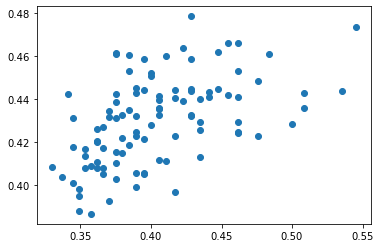

Loss1=8.759494, Loss12=0.002123, ValLoss1=8.759033, ValLoss2=0.017306
Loss1=8.774691, Loss12=0.002182, ValLoss1=8.814296, ValLoss2=0.016425
Loss1=8.753507, Loss12=0.002142, ValLoss1=8.768244, ValLoss2=0.016102
Loss1=8.741764, Loss12=0.002150, ValLoss1=8.832716, ValLoss2=0.015622
Loss1=8.767093, Loss12=0.002193, ValLoss1=8.841927, ValLoss2=0.016334
Loss1=8.741764, Loss12=0.002154, ValLoss1=8.759033, ValLoss2=0.015533
Loss1=8.761566, Loss12=0.002180, ValLoss1=8.777454, ValLoss2=0.018981
Loss1=8.743146, Loss12=0.002183, ValLoss1=8.805085, ValLoss2=0.015535
Loss1=8.739692, Loss12=0.002213, ValLoss1=8.703771, ValLoss2=0.016576
Loss1=8.761566, Loss12=0.002206, ValLoss1=8.869557, ValLoss2=0.017167


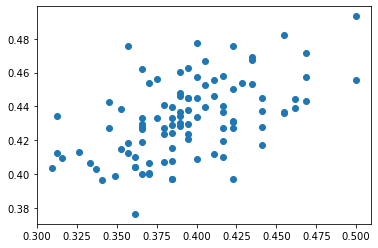

Loss1=8.756270, Loss12=0.002215, ValLoss1=8.759033, ValLoss2=0.016276
supervised: finished one epoch (15)!
Loss1=8.771007, Loss12=0.002176, ValLoss1=8.814296, ValLoss2=0.015165
Loss1=8.745448, Loss12=0.002246, ValLoss1=8.795875, ValLoss2=0.015746
Loss1=8.761797, Loss12=0.002214, ValLoss1=8.795875, ValLoss2=0.017135
Loss1=8.756501, Loss12=0.002064, ValLoss1=8.832716, ValLoss2=0.016935
Loss1=8.742225, Loss12=0.002046, ValLoss1=8.869557, ValLoss2=0.015507
Loss1=8.780448, Loss12=0.002065, ValLoss1=8.795875, ValLoss2=0.016356
Loss1=8.757422, Loss12=0.002056, ValLoss1=8.731402, ValLoss2=0.017201
Loss1=8.741994, Loss12=0.002055, ValLoss1=8.841926, ValLoss2=0.017383
Loss1=8.730942, Loss12=0.002002, ValLoss1=8.768244, ValLoss2=0.016118


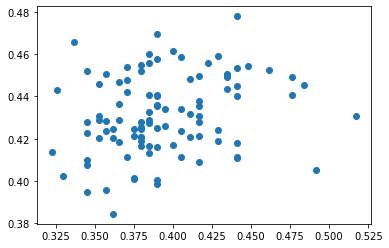

Loss1=8.762257, Loss12=0.002110, ValLoss1=8.795875, ValLoss2=0.017606
Loss1=8.762257, Loss12=0.002098, ValLoss1=8.841927, ValLoss2=0.016379
Loss1=8.758343, Loss12=0.002147, ValLoss1=8.768244, ValLoss2=0.017636
Loss1=8.765481, Loss12=0.002167, ValLoss1=8.814296, ValLoss2=0.017936
Loss1=8.748902, Loss12=0.002055, ValLoss1=8.795876, ValLoss2=0.017059
Loss1=8.765711, Loss12=0.002106, ValLoss1=8.823505, ValLoss2=0.016871
Loss1=8.739462, Loss12=0.002078, ValLoss1=8.777454, ValLoss2=0.014505
supervised: finished one epoch (16)!
Loss1=8.761566, Loss12=0.002103, ValLoss1=8.851137, ValLoss2=0.015681
Loss1=8.760185, Loss12=0.002000, ValLoss1=8.814296, ValLoss2=0.016543
Loss1=8.760876, Loss12=0.002099, ValLoss1=8.805085, ValLoss2=0.016337


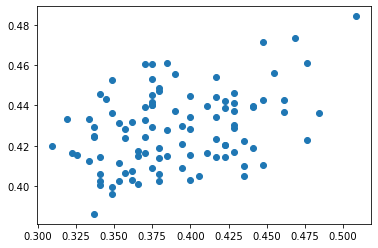

Loss1=8.756501, Loss12=0.002004, ValLoss1=8.786664, ValLoss2=0.014975
Loss1=8.753738, Loss12=0.002011, ValLoss1=8.795875, ValLoss2=0.016721
Loss1=8.772158, Loss12=0.002013, ValLoss1=8.768244, ValLoss2=0.017023
Loss1=8.754428, Loss12=0.001994, ValLoss1=8.823506, ValLoss2=0.017598
Loss1=8.761106, Loss12=0.001912, ValLoss1=8.906399, ValLoss2=0.016915
Loss1=8.753047, Loss12=0.001956, ValLoss1=8.887979, ValLoss2=0.016509
Loss1=8.773079, Loss12=0.002041, ValLoss1=8.694561, ValLoss2=0.017379
Loss1=8.750744, Loss12=0.002060, ValLoss1=8.768244, ValLoss2=0.017210
Loss1=8.749823, Loss12=0.002004, ValLoss1=8.722192, ValLoss2=0.015712
Loss1=8.769625, Loss12=0.002098, ValLoss1=8.786664, ValLoss2=0.015522


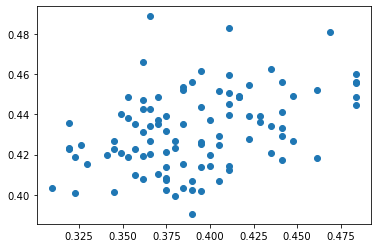

Loss1=8.752356, Loss12=0.001959, ValLoss1=8.712981, ValLoss2=0.016754
Loss1=8.737159, Loss12=0.001964, ValLoss1=8.823506, ValLoss2=0.015220
supervised: finished one epoch (17)!
Loss1=8.759033, Loss12=0.001990, ValLoss1=8.869557, ValLoss2=0.017309
Loss1=8.755349, Loss12=0.001891, ValLoss1=8.832716, ValLoss2=0.016253
Loss1=8.758113, Loss12=0.001918, ValLoss1=8.841926, ValLoss2=0.015976
Loss1=8.746830, Loss12=0.001855, ValLoss1=8.777454, ValLoss2=0.016616
Loss1=8.757191, Loss12=0.001959, ValLoss1=8.832716, ValLoss2=0.016497
Loss1=8.733705, Loss12=0.001893, ValLoss1=8.777454, ValLoss2=0.015327
Loss1=8.754889, Loss12=0.001902, ValLoss1=8.777454, ValLoss2=0.016294
Loss1=8.774231, Loss12=0.001941, ValLoss1=8.841926, ValLoss2=0.016380


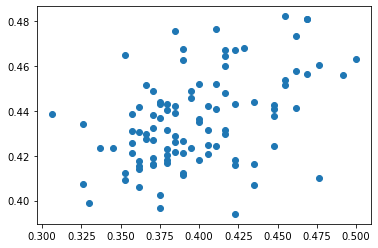

Loss1=8.759494, Loss12=0.001901, ValLoss1=8.841926, ValLoss2=0.015506
Loss1=8.755349, Loss12=0.001898, ValLoss1=8.795875, ValLoss2=0.016603
Loss1=8.747981, Loss12=0.001901, ValLoss1=8.814296, ValLoss2=0.014844
Loss1=8.756731, Loss12=0.001912, ValLoss1=8.703772, ValLoss2=0.015046
Loss1=8.746369, Loss12=0.001953, ValLoss1=8.841927, ValLoss2=0.016345
Loss1=8.769395, Loss12=0.001966, ValLoss1=8.832716, ValLoss2=0.015942
Loss1=8.737619, Loss12=0.001990, ValLoss1=8.795875, ValLoss2=0.016969
Loss1=8.778605, Loss12=0.001900, ValLoss1=8.777454, ValLoss2=0.016331
supervised: finished one epoch (18)!
Loss1=8.749823, Loss12=0.001878, ValLoss1=8.823506, ValLoss2=0.018327
Loss1=8.744297, Loss12=0.001911, ValLoss1=8.795875, ValLoss2=0.016719


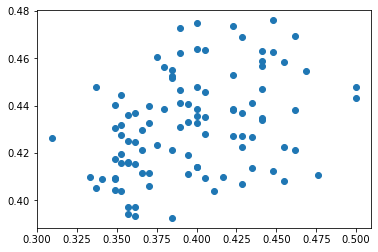

Loss1=8.748672, Loss12=0.001944, ValLoss1=8.777454, ValLoss2=0.015822
Loss1=8.749132, Loss12=0.001835, ValLoss1=8.768244, ValLoss2=0.015935
Loss1=8.756961, Loss12=0.001859, ValLoss1=8.777453, ValLoss2=0.015846
Loss1=8.758803, Loss12=0.001966, ValLoss1=8.749824, ValLoss2=0.015580
Loss1=8.759033, Loss12=0.001868, ValLoss1=8.712981, ValLoss2=0.016937
Loss1=8.771007, Loss12=0.001875, ValLoss1=8.722192, ValLoss2=0.017819
Loss1=8.761566, Loss12=0.001797, ValLoss1=8.805085, ValLoss2=0.015114
Loss1=8.737620, Loss12=0.001868, ValLoss1=8.712981, ValLoss2=0.016737
Loss1=8.758343, Loss12=0.001833, ValLoss1=8.851137, ValLoss2=0.016765
Loss1=8.747290, Loss12=0.001780, ValLoss1=8.860348, ValLoss2=0.018032


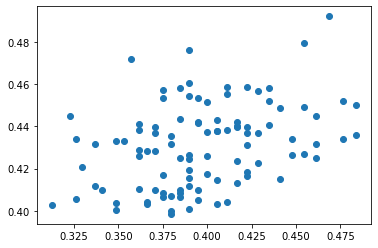

Loss1=8.770086, Loss12=0.001871, ValLoss1=8.805085, ValLoss2=0.018176
Loss1=8.750054, Loss12=0.001845, ValLoss1=8.786665, ValLoss2=0.015538
Loss1=8.749823, Loss12=0.001850, ValLoss1=8.823506, ValLoss2=0.016243
Loss1=8.749132, Loss12=0.001879, ValLoss1=8.777454, ValLoss2=0.017158
supervised: finished one epoch (19)!
Loss1=8.749593, Loss12=0.001802, ValLoss1=8.777454, ValLoss2=0.015990
Loss1=8.736008, Loss12=0.001682, ValLoss1=8.759033, ValLoss2=0.016857
Loss1=8.743376, Loss12=0.001842, ValLoss1=8.749824, ValLoss2=0.017007
Loss1=8.764790, Loss12=0.001748, ValLoss1=8.740613, ValLoss2=0.015953
Loss1=8.747751, Loss12=0.001839, ValLoss1=8.841927, ValLoss2=0.017411
Loss1=8.752126, Loss12=0.001820, ValLoss1=8.786665, ValLoss2=0.015829


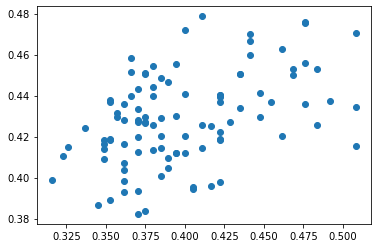

Loss1=8.744758, Loss12=0.001764, ValLoss1=8.814296, ValLoss2=0.017629
Loss1=8.749363, Loss12=0.001721, ValLoss1=8.768244, ValLoss2=0.017786
Loss1=8.767783, Loss12=0.001804, ValLoss1=8.841926, ValLoss2=0.017305
Loss1=8.769625, Loss12=0.001805, ValLoss1=8.694561, ValLoss2=0.017401
Loss1=8.736008, Loss12=0.001849, ValLoss1=8.795875, ValLoss2=0.016022
Loss1=8.759494, Loss12=0.001773, ValLoss1=8.768244, ValLoss2=0.016997
Loss1=8.753968, Loss12=0.001808, ValLoss1=8.768244, ValLoss2=0.018054
Loss1=8.761336, Loss12=0.001811, ValLoss1=8.814296, ValLoss2=0.018463
Loss1=8.752126, Loss12=0.001751, ValLoss1=8.841927, ValLoss2=0.018052
supervised: finished one epoch (20)!
Loss1=8.758112, Loss12=0.001682, ValLoss1=8.749823, ValLoss2=0.018641


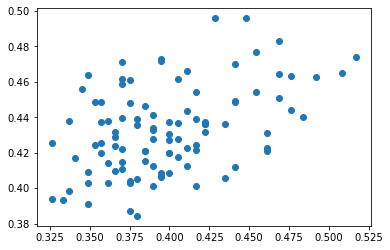

Loss1=8.758112, Loss12=0.001697, ValLoss1=8.851137, ValLoss2=0.017984
Loss1=8.765711, Loss12=0.001723, ValLoss1=8.878768, ValLoss2=0.016734
Loss1=8.765941, Loss12=0.001706, ValLoss1=8.823506, ValLoss2=0.017084
Loss1=8.745678, Loss12=0.001681, ValLoss1=8.841927, ValLoss2=0.017652
Loss1=8.749132, Loss12=0.001688, ValLoss1=8.768244, ValLoss2=0.015603
Loss1=8.769625, Loss12=0.001666, ValLoss1=8.860348, ValLoss2=0.015843
Loss1=8.748211, Loss12=0.001707, ValLoss1=8.786665, ValLoss2=0.016268
Loss1=8.745448, Loss12=0.001768, ValLoss1=8.786665, ValLoss2=0.016113
Loss1=8.760645, Loss12=0.001727, ValLoss1=8.740614, ValLoss2=0.014940
Loss1=8.762948, Loss12=0.001771, ValLoss1=8.795875, ValLoss2=0.014539


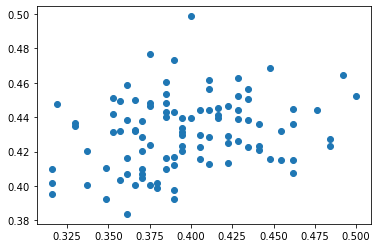

Loss1=8.759494, Loss12=0.001708, ValLoss1=8.740613, ValLoss2=0.016497
Loss1=8.758573, Loss12=0.001754, ValLoss1=8.814296, ValLoss2=0.014669
Loss1=8.754659, Loss12=0.001694, ValLoss1=8.841926, ValLoss2=0.015353
Loss1=8.742915, Loss12=0.001683, ValLoss1=8.860348, ValLoss2=0.016238
Loss1=8.762257, Loss12=0.001777, ValLoss1=8.722192, ValLoss2=0.017480
supervised: finished one epoch (21)!
Loss1=8.740152, Loss12=0.001682, ValLoss1=8.786664, ValLoss2=0.017520
Loss1=8.772619, Loss12=0.001660, ValLoss1=8.841927, ValLoss2=0.016015
Loss1=8.749363, Loss12=0.001653, ValLoss1=8.823506, ValLoss2=0.014917
Loss1=8.748211, Loss12=0.001656, ValLoss1=8.814296, ValLoss2=0.015707
Loss1=8.764329, Loss12=0.001633, ValLoss1=8.805085, ValLoss2=0.017740


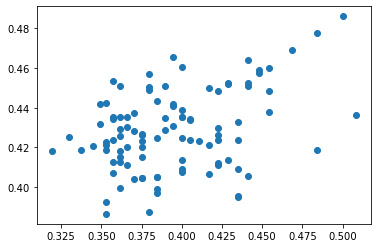

Loss1=8.770316, Loss12=0.001689, ValLoss1=8.768244, ValLoss2=0.015982
Loss1=8.772619, Loss12=0.001640, ValLoss1=8.805085, ValLoss2=0.015804
Loss1=8.757882, Loss12=0.001651, ValLoss1=8.786665, ValLoss2=0.016353
Loss1=8.760645, Loss12=0.001648, ValLoss1=8.851137, ValLoss2=0.015581
Loss1=8.756961, Loss12=0.001677, ValLoss1=8.906399, ValLoss2=0.013565
Loss1=8.747060, Loss12=0.001655, ValLoss1=8.777454, ValLoss2=0.016950
Loss1=8.764099, Loss12=0.001744, ValLoss1=8.759033, ValLoss2=0.015840
Loss1=8.757422, Loss12=0.001627, ValLoss1=8.860348, ValLoss2=0.015853
Loss1=8.745909, Loss12=0.001687, ValLoss1=8.768244, ValLoss2=0.015832
Loss1=8.729330, Loss12=0.001675, ValLoss1=8.768244, ValLoss2=0.016946


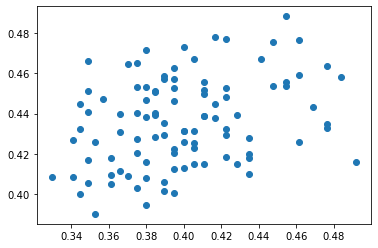

Loss1=8.763869, Loss12=0.001746, ValLoss1=8.666930, ValLoss2=0.017988
supervised: finished one epoch (22)!
Loss1=8.746830, Loss12=0.001648, ValLoss1=8.777454, ValLoss2=0.016324
Loss1=8.768704, Loss12=0.001556, ValLoss1=8.814296, ValLoss2=0.015564
Loss1=8.764790, Loss12=0.001681, ValLoss1=8.777454, ValLoss2=0.017173
Loss1=8.748442, Loss12=0.001644, ValLoss1=8.841927, ValLoss2=0.017509
Loss1=8.763869, Loss12=0.001583, ValLoss1=8.777454, ValLoss2=0.017342
Loss1=8.759955, Loss12=0.001608, ValLoss1=8.832716, ValLoss2=0.016850
Loss1=8.746369, Loss12=0.001632, ValLoss1=8.749824, ValLoss2=0.015521
Loss1=8.768935, Loss12=0.001628, ValLoss1=8.878768, ValLoss2=0.017592
Loss1=8.768014, Loss12=0.001581, ValLoss1=8.768244, ValLoss2=0.016528


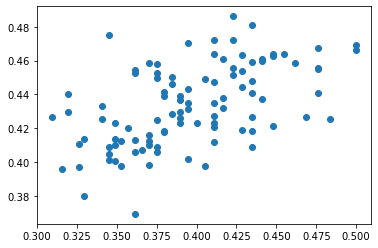

Loss1=8.763408, Loss12=0.001689, ValLoss1=8.841927, ValLoss2=0.016390
Loss1=8.756501, Loss12=0.001655, ValLoss1=8.841927, ValLoss2=0.016539
Loss1=8.747751, Loss12=0.001616, ValLoss1=8.786665, ValLoss2=0.016489
Loss1=8.754659, Loss12=0.001574, ValLoss1=8.823506, ValLoss2=0.017071
Loss1=8.762718, Loss12=0.001540, ValLoss1=8.851137, ValLoss2=0.017400
Loss1=8.742685, Loss12=0.001614, ValLoss1=8.795875, ValLoss2=0.016697
Loss1=8.764560, Loss12=0.001633, ValLoss1=8.768244, ValLoss2=0.016471
supervised: finished one epoch (23)!
Loss1=8.747751, Loss12=0.001526, ValLoss1=8.759033, ValLoss2=0.016244
Loss1=8.770546, Loss12=0.001556, ValLoss1=8.832716, ValLoss2=0.018454
Loss1=8.758573, Loss12=0.001549, ValLoss1=8.805085, ValLoss2=0.015748


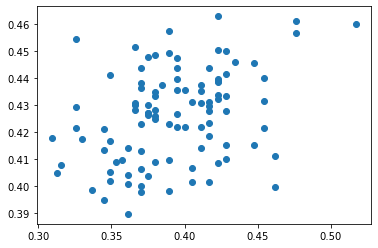

Loss1=8.759033, Loss12=0.001599, ValLoss1=8.823506, ValLoss2=0.015571
Loss1=8.752586, Loss12=0.001598, ValLoss1=8.795875, ValLoss2=0.017173
Loss1=8.754198, Loss12=0.001595, ValLoss1=8.841927, ValLoss2=0.016059
Loss1=8.751895, Loss12=0.001584, ValLoss1=8.832716, ValLoss2=0.016835
Loss1=8.772389, Loss12=0.001601, ValLoss1=8.786665, ValLoss2=0.015176
Loss1=8.749593, Loss12=0.001558, ValLoss1=8.786664, ValLoss2=0.017842
Loss1=8.759724, Loss12=0.001547, ValLoss1=8.759033, ValLoss2=0.017201
Loss1=8.746600, Loss12=0.001499, ValLoss1=8.777454, ValLoss2=0.016759
Loss1=8.755580, Loss12=0.001679, ValLoss1=8.832716, ValLoss2=0.016520
Loss1=8.753738, Loss12=0.001556, ValLoss1=8.887979, ValLoss2=0.016631


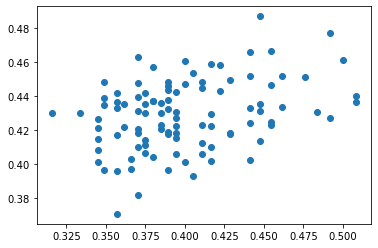

Loss1=8.750053, Loss12=0.001563, ValLoss1=8.832716, ValLoss2=0.014344
Loss1=8.753738, Loss12=0.001596, ValLoss1=8.777454, ValLoss2=0.017080
supervised: finished one epoch (24)!
Loss1=8.755119, Loss12=0.001582, ValLoss1=8.823506, ValLoss2=0.017140
Loss1=8.751435, Loss12=0.001530, ValLoss1=8.768244, ValLoss2=0.016203
Loss1=8.755349, Loss12=0.001572, ValLoss1=8.823506, ValLoss2=0.016419
Loss1=8.745448, Loss12=0.001593, ValLoss1=8.869557, ValLoss2=0.016514
Loss1=8.752586, Loss12=0.001500, ValLoss1=8.768244, ValLoss2=0.014346
Loss1=8.747751, Loss12=0.001492, ValLoss1=8.805085, ValLoss2=0.016025
Loss1=8.763408, Loss12=0.001557, ValLoss1=8.768244, ValLoss2=0.016358
Loss1=8.752817, Loss12=0.001427, ValLoss1=8.814296, ValLoss2=0.015571


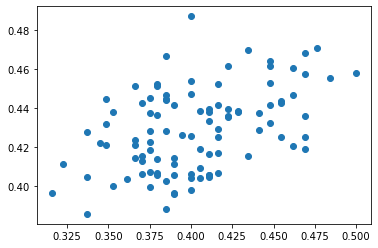

Loss1=8.757422, Loss12=0.001506, ValLoss1=8.823506, ValLoss2=0.016475
Loss1=8.751435, Loss12=0.001466, ValLoss1=8.786665, ValLoss2=0.015795
Loss1=8.764790, Loss12=0.001491, ValLoss1=8.777453, ValLoss2=0.017339
Loss1=8.765250, Loss12=0.001405, ValLoss1=8.805085, ValLoss2=0.015497
Loss1=8.764099, Loss12=0.001529, ValLoss1=8.786665, ValLoss2=0.016257
Loss1=8.760185, Loss12=0.001464, ValLoss1=8.841927, ValLoss2=0.017243
Loss1=8.748902, Loss12=0.001543, ValLoss1=8.832716, ValLoss2=0.017122
Loss1=8.742455, Loss12=0.001518, ValLoss1=8.851137, ValLoss2=0.016306
supervised: finished one epoch (25)!
Loss1=8.744067, Loss12=0.001487, ValLoss1=8.814296, ValLoss2=0.016092
Loss1=8.759955, Loss12=0.001469, ValLoss1=8.759033, ValLoss2=0.016346


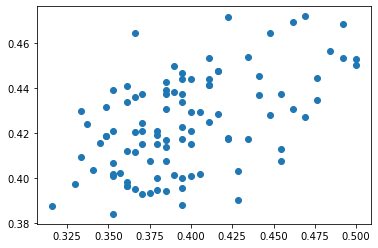

Loss1=8.741304, Loss12=0.001507, ValLoss1=8.805085, ValLoss2=0.015941
Loss1=8.750053, Loss12=0.001485, ValLoss1=8.841927, ValLoss2=0.015578
Loss1=8.756040, Loss12=0.001429, ValLoss1=8.768244, ValLoss2=0.015991
Loss1=8.762718, Loss12=0.001485, ValLoss1=8.786665, ValLoss2=0.016660
Loss1=8.762027, Loss12=0.001486, ValLoss1=8.703772, ValLoss2=0.016443
Loss1=8.744757, Loss12=0.001481, ValLoss1=8.722192, ValLoss2=0.018472
Loss1=8.757652, Loss12=0.001472, ValLoss1=8.851137, ValLoss2=0.016136
Loss1=8.770546, Loss12=0.001455, ValLoss1=8.841927, ValLoss2=0.017717
Loss1=8.761106, Loss12=0.001468, ValLoss1=8.851137, ValLoss2=0.017178
Loss1=8.757422, Loss12=0.001503, ValLoss1=8.740613, ValLoss2=0.015383


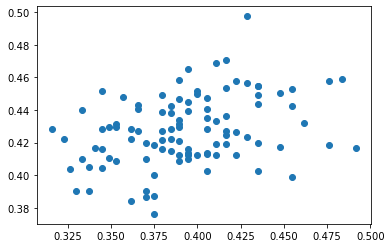

Loss1=8.756731, Loss12=0.001451, ValLoss1=8.685351, ValLoss2=0.015219
Loss1=8.751205, Loss12=0.001528, ValLoss1=8.777454, ValLoss2=0.015734
Loss1=8.754198, Loss12=0.001456, ValLoss1=8.759033, ValLoss2=0.016121
Loss1=8.753047, Loss12=0.001484, ValLoss1=8.795875, ValLoss2=0.015643
supervised: finished one epoch (26)!
Loss1=8.747981, Loss12=0.001392, ValLoss1=8.786665, ValLoss2=0.015868
Loss1=8.757882, Loss12=0.001414, ValLoss1=8.786664, ValLoss2=0.015665
Loss1=8.750744, Loss12=0.001448, ValLoss1=8.777454, ValLoss2=0.015897
Loss1=8.753047, Loss12=0.001410, ValLoss1=8.841927, ValLoss2=0.016215
Loss1=8.753047, Loss12=0.001392, ValLoss1=8.887979, ValLoss2=0.016597
Loss1=8.741994, Loss12=0.001427, ValLoss1=8.795875, ValLoss2=0.016071


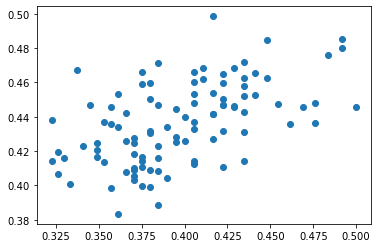

Loss1=8.779987, Loss12=0.001466, ValLoss1=8.906399, ValLoss2=0.016413
Loss1=8.763639, Loss12=0.001399, ValLoss1=8.786664, ValLoss2=0.016556
Loss1=8.748672, Loss12=0.001466, ValLoss1=8.878768, ValLoss2=0.016315
Loss1=8.753507, Loss12=0.001395, ValLoss1=8.712981, ValLoss2=0.016120
Loss1=8.757882, Loss12=0.001403, ValLoss1=8.795875, ValLoss2=0.016602
Loss1=8.757652, Loss12=0.001447, ValLoss1=8.740613, ValLoss2=0.015351
Loss1=8.749363, Loss12=0.001410, ValLoss1=8.841927, ValLoss2=0.015851
Loss1=8.779757, Loss12=0.001481, ValLoss1=8.777454, ValLoss2=0.015114
Loss1=8.769165, Loss12=0.001433, ValLoss1=8.777453, ValLoss2=0.014808
supervised: finished one epoch (27)!
Loss1=8.753968, Loss12=0.001407, ValLoss1=8.869557, ValLoss2=0.017446


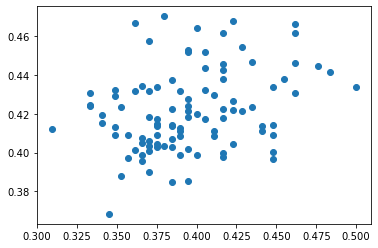

Loss1=8.762027, Loss12=0.001380, ValLoss1=8.841927, ValLoss2=0.016197
Loss1=8.768704, Loss12=0.001379, ValLoss1=8.777454, ValLoss2=0.016333
Loss1=8.750284, Loss12=0.001377, ValLoss1=8.860348, ValLoss2=0.014662
Loss1=8.754198, Loss12=0.001379, ValLoss1=8.786664, ValLoss2=0.015568
Loss1=8.771928, Loss12=0.001359, ValLoss1=8.786664, ValLoss2=0.016125
Loss1=8.760415, Loss12=0.001368, ValLoss1=8.832716, ValLoss2=0.016462
Loss1=8.765941, Loss12=0.001380, ValLoss1=8.823506, ValLoss2=0.017412
Loss1=8.752817, Loss12=0.001383, ValLoss1=8.814296, ValLoss2=0.016547
Loss1=8.767553, Loss12=0.001460, ValLoss1=8.795875, ValLoss2=0.017948
Loss1=8.747060, Loss12=0.001392, ValLoss1=8.786665, ValLoss2=0.017959


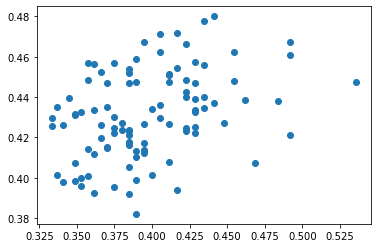

Loss1=8.745909, Loss12=0.001408, ValLoss1=8.841927, ValLoss2=0.016245
Loss1=8.755810, Loss12=0.001313, ValLoss1=8.777453, ValLoss2=0.017065
Loss1=8.759034, Loss12=0.001396, ValLoss1=8.777454, ValLoss2=0.016725
Loss1=8.738080, Loss12=0.001392, ValLoss1=8.823506, ValLoss2=0.016393
Loss1=8.750744, Loss12=0.001389, ValLoss1=8.786665, ValLoss2=0.016429
supervised: finished one epoch (28)!
Loss1=8.755580, Loss12=0.001362, ValLoss1=8.832716, ValLoss2=0.016242
Loss1=8.767323, Loss12=0.001333, ValLoss1=8.805085, ValLoss2=0.016444
Loss1=8.748902, Loss12=0.001358, ValLoss1=8.897188, ValLoss2=0.014584
Loss1=8.757191, Loss12=0.001342, ValLoss1=8.897188, ValLoss2=0.015855
Loss1=8.750053, Loss12=0.001369, ValLoss1=8.786665, ValLoss2=0.016643


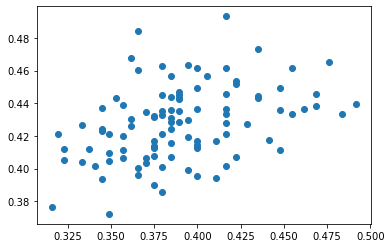

Loss1=8.763408, Loss12=0.001350, ValLoss1=8.869558, ValLoss2=0.017120
Loss1=8.762257, Loss12=0.001385, ValLoss1=8.749824, ValLoss2=0.015885
Loss1=8.754889, Loss12=0.001384, ValLoss1=8.841926, ValLoss2=0.016382
Loss1=8.762948, Loss12=0.001356, ValLoss1=8.731402, ValLoss2=0.015984
Loss1=8.772849, Loss12=0.001360, ValLoss1=8.814296, ValLoss2=0.016661
Loss1=8.741304, Loss12=0.001362, ValLoss1=8.749823, ValLoss2=0.015607
Loss1=8.767323, Loss12=0.001357, ValLoss1=8.841927, ValLoss2=0.017140
Loss1=8.758803, Loss12=0.001380, ValLoss1=8.749823, ValLoss2=0.016091
Loss1=8.778605, Loss12=0.001334, ValLoss1=8.841927, ValLoss2=0.016140
Loss1=8.769856, Loss12=0.001383, ValLoss1=8.814296, ValLoss2=0.017599


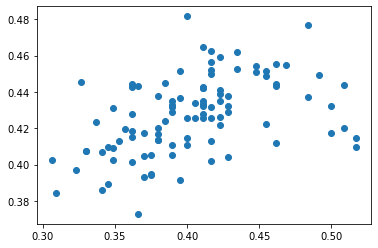

Loss1=8.760415, Loss12=0.001382, ValLoss1=8.786665, ValLoss2=0.015230
supervised: finished one epoch (29)!
Loss1=8.763408, Loss12=0.001350, ValLoss1=8.795875, ValLoss2=0.014638
Loss1=8.753277, Loss12=0.001282, ValLoss1=8.823506, ValLoss2=0.014204
Loss1=8.755810, Loss12=0.001311, ValLoss1=8.805085, ValLoss2=0.016350
Loss1=8.762027, Loss12=0.001302, ValLoss1=8.722192, ValLoss2=0.016636
Loss1=8.749593, Loss12=0.001300, ValLoss1=8.786665, ValLoss2=0.017432
Loss1=8.757882, Loss12=0.001353, ValLoss1=8.768244, ValLoss2=0.017189
Loss1=8.769856, Loss12=0.001325, ValLoss1=8.795876, ValLoss2=0.014235
Loss1=8.744988, Loss12=0.001322, ValLoss1=8.823506, ValLoss2=0.016270
Loss1=8.760645, Loss12=0.001334, ValLoss1=8.823506, ValLoss2=0.015500


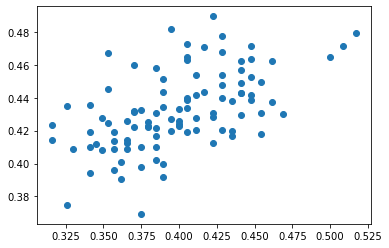

Loss1=8.739922, Loss12=0.001325, ValLoss1=8.768244, ValLoss2=0.016650
Loss1=8.734626, Loss12=0.001351, ValLoss1=8.805085, ValLoss2=0.017284
Loss1=8.747290, Loss12=0.001343, ValLoss1=8.860348, ValLoss2=0.017860
Loss1=8.749132, Loss12=0.001305, ValLoss1=8.841926, ValLoss2=0.015764
Loss1=8.764560, Loss12=0.001338, ValLoss1=8.777454, ValLoss2=0.015437
Loss1=8.753738, Loss12=0.001344, ValLoss1=8.759033, ValLoss2=0.015291
Loss1=8.741994, Loss12=0.001383, ValLoss1=8.832716, ValLoss2=0.017352
supervised: finished one epoch (30)!
Loss1=8.753738, Loss12=0.001260, ValLoss1=8.832716, ValLoss2=0.014561
Loss1=8.757882, Loss12=0.001276, ValLoss1=8.759033, ValLoss2=0.015649
Loss1=8.748211, Loss12=0.001288, ValLoss1=8.814296, ValLoss2=0.014964


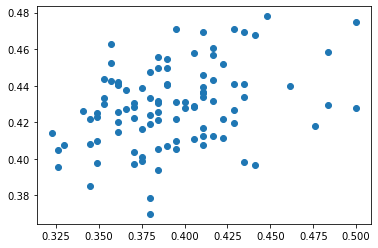

Loss1=8.762718, Loss12=0.001285, ValLoss1=8.749824, ValLoss2=0.015078
Loss1=8.744988, Loss12=0.001286, ValLoss1=8.823506, ValLoss2=0.015315
Loss1=8.757422, Loss12=0.001259, ValLoss1=8.823506, ValLoss2=0.016580
Loss1=8.754889, Loss12=0.001306, ValLoss1=8.869557, ValLoss2=0.015781
Loss1=8.761797, Loss12=0.001276, ValLoss1=8.786665, ValLoss2=0.016148
Loss1=8.746369, Loss12=0.001266, ValLoss1=8.814296, ValLoss2=0.016210
Loss1=8.772389, Loss12=0.001269, ValLoss1=8.805085, ValLoss2=0.016333
Loss1=8.746600, Loss12=0.001297, ValLoss1=8.934030, ValLoss2=0.017258
Loss1=8.736238, Loss12=0.001291, ValLoss1=8.860348, ValLoss2=0.016693
Loss1=8.750974, Loss12=0.001281, ValLoss1=8.814296, ValLoss2=0.015896


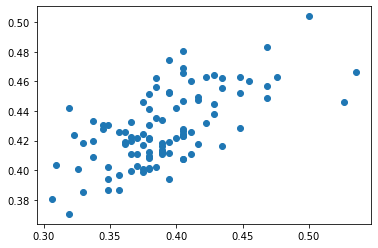

Loss1=8.766172, Loss12=0.001352, ValLoss1=8.777454, ValLoss2=0.016104
Loss1=8.763869, Loss12=0.001259, ValLoss1=8.786665, ValLoss2=0.015417
supervised: finished one epoch (31)!
Loss1=8.753968, Loss12=0.001255, ValLoss1=8.749824, ValLoss2=0.015662
Loss1=8.752126, Loss12=0.001240, ValLoss1=8.841927, ValLoss2=0.016333
Loss1=8.753738, Loss12=0.001239, ValLoss1=8.823506, ValLoss2=0.015845
Loss1=8.756731, Loss12=0.001273, ValLoss1=8.805085, ValLoss2=0.016204
Loss1=8.756501, Loss12=0.001194, ValLoss1=8.823506, ValLoss2=0.016520
Loss1=8.750053, Loss12=0.001196, ValLoss1=8.768244, ValLoss2=0.015012
Loss1=8.763869, Loss12=0.001369, ValLoss1=8.814296, ValLoss2=0.016484
Loss1=8.753507, Loss12=0.001243, ValLoss1=8.740612, ValLoss2=0.016017


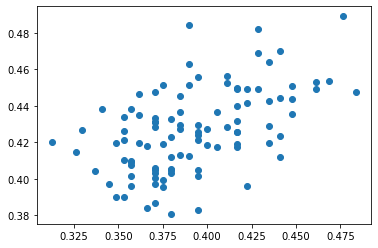

Loss1=8.753277, Loss12=0.001271, ValLoss1=8.841926, ValLoss2=0.015637
Loss1=8.768935, Loss12=0.001227, ValLoss1=8.832716, ValLoss2=0.016870
Loss1=8.759954, Loss12=0.001238, ValLoss1=8.731402, ValLoss2=0.015278
Loss1=8.744067, Loss12=0.001248, ValLoss1=8.768244, ValLoss2=0.014870
Loss1=8.745678, Loss12=0.001316, ValLoss1=8.795875, ValLoss2=0.014541
Loss1=8.747521, Loss12=0.001253, ValLoss1=8.759033, ValLoss2=0.014912
Loss1=8.765251, Loss12=0.001266, ValLoss1=8.860348, ValLoss2=0.014625
Loss1=8.758573, Loss12=0.001296, ValLoss1=8.832716, ValLoss2=0.016451
supervised: finished one epoch (32)!
Loss1=8.748442, Loss12=0.001244, ValLoss1=8.814296, ValLoss2=0.017607
Loss1=8.755580, Loss12=0.001214, ValLoss1=8.805085, ValLoss2=0.015504


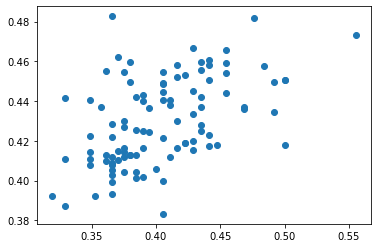

Loss1=8.753968, Loss12=0.001260, ValLoss1=8.777454, ValLoss2=0.014816
Loss1=8.753507, Loss12=0.001207, ValLoss1=8.749823, ValLoss2=0.016153
Loss1=8.754198, Loss12=0.001262, ValLoss1=8.805085, ValLoss2=0.016249
Loss1=8.743146, Loss12=0.001246, ValLoss1=8.851137, ValLoss2=0.015243
Loss1=8.742225, Loss12=0.001261, ValLoss1=8.795875, ValLoss2=0.016335
Loss1=8.755349, Loss12=0.001245, ValLoss1=8.768244, ValLoss2=0.015770
Loss1=8.765481, Loss12=0.001246, ValLoss1=8.777454, ValLoss2=0.015849
Loss1=8.739692, Loss12=0.001242, ValLoss1=8.851136, ValLoss2=0.015345
Loss1=8.736929, Loss12=0.001218, ValLoss1=8.795875, ValLoss2=0.016299
Loss1=8.757422, Loss12=0.001244, ValLoss1=8.823506, ValLoss2=0.017600


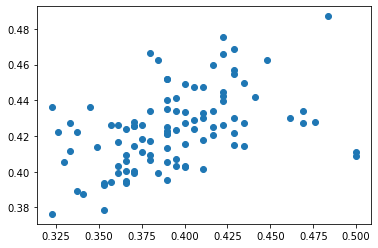

Loss1=8.746830, Loss12=0.001269, ValLoss1=8.795875, ValLoss2=0.017266
Loss1=8.764790, Loss12=0.001209, ValLoss1=8.814296, ValLoss2=0.015905
Loss1=8.751665, Loss12=0.001263, ValLoss1=8.777454, ValLoss2=0.017035
Loss1=8.755810, Loss12=0.001217, ValLoss1=8.805085, ValLoss2=0.017326
supervised: finished one epoch (33)!
Loss1=8.750284, Loss12=0.001170, ValLoss1=8.759033, ValLoss2=0.016669
Loss1=8.746139, Loss12=0.001206, ValLoss1=8.795875, ValLoss2=0.016216
Loss1=8.751435, Loss12=0.001200, ValLoss1=8.722192, ValLoss2=0.016185
Loss1=8.748672, Loss12=0.001218, ValLoss1=8.841927, ValLoss2=0.015802
Loss1=8.792191, Loss12=0.001184, ValLoss1=8.759033, ValLoss2=0.015786
Loss1=8.751895, Loss12=0.001168, ValLoss1=8.823506, ValLoss2=0.016768


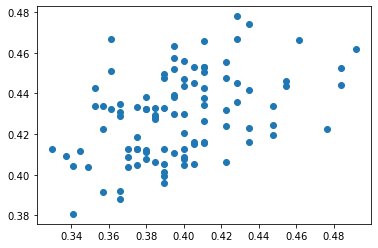

Loss1=8.753968, Loss12=0.001221, ValLoss1=8.786665, ValLoss2=0.015874
Loss1=8.752586, Loss12=0.001166, ValLoss1=8.795875, ValLoss2=0.017041
Loss1=8.747290, Loss12=0.001207, ValLoss1=8.777454, ValLoss2=0.015905
Loss1=8.757882, Loss12=0.001173, ValLoss1=8.759033, ValLoss2=0.016753
Loss1=8.760185, Loss12=0.001175, ValLoss1=8.851136, ValLoss2=0.016090
Loss1=8.748211, Loss12=0.001205, ValLoss1=8.832716, ValLoss2=0.017464
Loss1=8.741764, Loss12=0.001198, ValLoss1=8.841927, ValLoss2=0.016662
Loss1=8.747981, Loss12=0.001179, ValLoss1=8.676141, ValLoss2=0.017120
Loss1=8.758112, Loss12=0.001219, ValLoss1=8.814296, ValLoss2=0.016858
supervised: finished one epoch (34)!
Loss1=8.773079, Loss12=0.001177, ValLoss1=8.841926, ValLoss2=0.016705


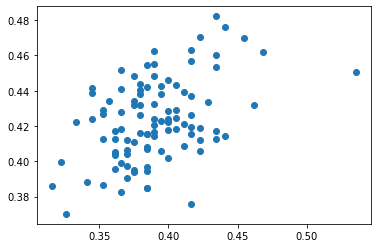

Loss1=8.750974, Loss12=0.001189, ValLoss1=8.814296, ValLoss2=0.017497
Loss1=8.736929, Loss12=0.001163, ValLoss1=8.823506, ValLoss2=0.017289
Loss1=8.739462, Loss12=0.001192, ValLoss1=8.878768, ValLoss2=0.017274
Loss1=8.765711, Loss12=0.001193, ValLoss1=8.814296, ValLoss2=0.016408
Loss1=8.744757, Loss12=0.001134, ValLoss1=8.814296, ValLoss2=0.016822
Loss1=8.758343, Loss12=0.001127, ValLoss1=8.869557, ValLoss2=0.016493
Loss1=8.750514, Loss12=0.001179, ValLoss1=8.795875, ValLoss2=0.016689
Loss1=8.765481, Loss12=0.001151, ValLoss1=8.805085, ValLoss2=0.016709
Loss1=8.742225, Loss12=0.001180, ValLoss1=8.768244, ValLoss2=0.016328
Loss1=8.761106, Loss12=0.001153, ValLoss1=8.786665, ValLoss2=0.017930


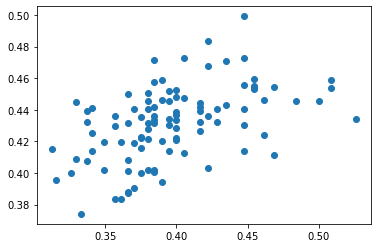

Loss1=8.776533, Loss12=0.001188, ValLoss1=8.832716, ValLoss2=0.016488
Loss1=8.772849, Loss12=0.001198, ValLoss1=8.786665, ValLoss2=0.016622
Loss1=8.760645, Loss12=0.001174, ValLoss1=8.722192, ValLoss2=0.016495
Loss1=8.760876, Loss12=0.001224, ValLoss1=8.851136, ValLoss2=0.016081
Loss1=8.762257, Loss12=0.001204, ValLoss1=8.823505, ValLoss2=0.015850
supervised: finished one epoch (35)!
Loss1=8.752586, Loss12=0.001135, ValLoss1=8.805085, ValLoss2=0.016001
Loss1=8.744988, Loss12=0.001118, ValLoss1=8.786665, ValLoss2=0.015641
Loss1=8.767783, Loss12=0.001130, ValLoss1=8.795875, ValLoss2=0.016078
Loss1=8.761106, Loss12=0.001152, ValLoss1=8.795875, ValLoss2=0.016123
Loss1=8.759264, Loss12=0.001124, ValLoss1=8.759033, ValLoss2=0.016442


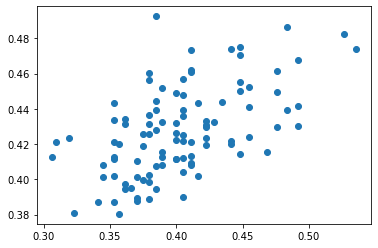

Loss1=8.770546, Loss12=0.001149, ValLoss1=8.786665, ValLoss2=0.016409
Loss1=8.762027, Loss12=0.001134, ValLoss1=8.777454, ValLoss2=0.017908
Loss1=8.744297, Loss12=0.001137, ValLoss1=8.823506, ValLoss2=0.017958
Loss1=8.763639, Loss12=0.001138, ValLoss1=8.823506, ValLoss2=0.014793
Loss1=8.767553, Loss12=0.001135, ValLoss1=8.740613, ValLoss2=0.016732
Loss1=8.745448, Loss12=0.001168, ValLoss1=8.823506, ValLoss2=0.016618
Loss1=8.771928, Loss12=0.001179, ValLoss1=8.823506, ValLoss2=0.018629
Loss1=8.751896, Loss12=0.001133, ValLoss1=8.777454, ValLoss2=0.017147
Loss1=8.749132, Loss12=0.001129, ValLoss1=8.860348, ValLoss2=0.016948
Loss1=8.756040, Loss12=0.001174, ValLoss1=8.795875, ValLoss2=0.017410


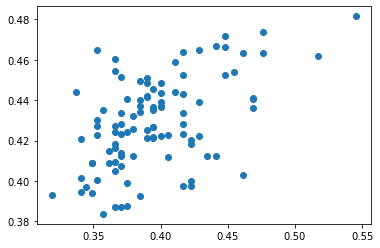

Loss1=8.763408, Loss12=0.001164, ValLoss1=8.841926, ValLoss2=0.017778
supervised: finished one epoch (36)!
Loss1=8.767093, Loss12=0.001093, ValLoss1=8.851137, ValLoss2=0.017367
Loss1=8.757191, Loss12=0.001106, ValLoss1=8.823506, ValLoss2=0.016465
Loss1=8.763408, Loss12=0.001130, ValLoss1=8.887978, ValLoss2=0.016673
Loss1=8.763639, Loss12=0.001101, ValLoss1=8.878769, ValLoss2=0.018315
Loss1=8.761336, Loss12=0.001102, ValLoss1=8.768244, ValLoss2=0.016401
Loss1=8.761106, Loss12=0.001092, ValLoss1=8.731402, ValLoss2=0.015916
Loss1=8.765941, Loss12=0.001103, ValLoss1=8.777454, ValLoss2=0.017027
Loss1=8.756961, Loss12=0.001117, ValLoss1=8.740614, ValLoss2=0.017763
Loss1=8.751435, Loss12=0.001146, ValLoss1=8.759033, ValLoss2=0.017301


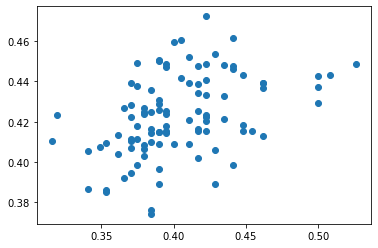

Loss1=8.758803, Loss12=0.001196, ValLoss1=8.832716, ValLoss2=0.015901
Loss1=8.767323, Loss12=0.001115, ValLoss1=8.805085, ValLoss2=0.016246
Loss1=8.741764, Loss12=0.001129, ValLoss1=8.740613, ValLoss2=0.018207
Loss1=8.778836, Loss12=0.001148, ValLoss1=8.795875, ValLoss2=0.016009
Loss1=8.776303, Loss12=0.001124, ValLoss1=8.759033, ValLoss2=0.017802
Loss1=8.745218, Loss12=0.001119, ValLoss1=8.832716, ValLoss2=0.017222
supervised: finished one epoch (37)!
Loss1=8.760876, Loss12=0.001129, ValLoss1=8.823506, ValLoss2=0.017134
Loss1=8.760415, Loss12=0.001101, ValLoss1=8.795875, ValLoss2=0.017728
Loss1=8.750744, Loss12=0.001126, ValLoss1=8.805085, ValLoss2=0.016784
Loss1=8.764560, Loss12=0.001070, ValLoss1=8.722192, ValLoss2=0.017650


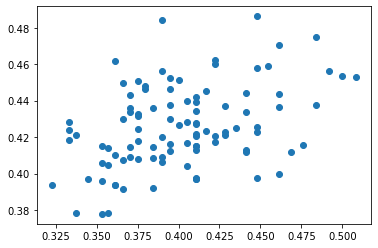

Loss1=8.744988, Loss12=0.001102, ValLoss1=8.777454, ValLoss2=0.017203
Loss1=8.763639, Loss12=0.001130, ValLoss1=8.777454, ValLoss2=0.018835
Loss1=8.774000, Loss12=0.001123, ValLoss1=8.795875, ValLoss2=0.016602
Loss1=8.750744, Loss12=0.001095, ValLoss1=8.795875, ValLoss2=0.016642
Loss1=8.767323, Loss12=0.001109, ValLoss1=8.823506, ValLoss2=0.015487
Loss1=8.763869, Loss12=0.001107, ValLoss1=8.805085, ValLoss2=0.016503
Loss1=8.743836, Loss12=0.001096, ValLoss1=8.731402, ValLoss2=0.016694
Loss1=8.744297, Loss12=0.001122, ValLoss1=8.823506, ValLoss2=0.018068
Loss1=8.770316, Loss12=0.001096, ValLoss1=8.814296, ValLoss2=0.016664
Loss1=8.759264, Loss12=0.001076, ValLoss1=8.740613, ValLoss2=0.016995


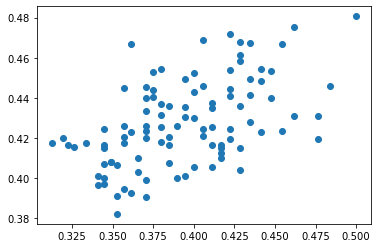

Loss1=8.740843, Loss12=0.001082, ValLoss1=8.814296, ValLoss2=0.017752
Loss1=8.762718, Loss12=0.001130, ValLoss1=8.768244, ValLoss2=0.018479
supervised: finished one epoch (38)!
Loss1=8.763869, Loss12=0.001096, ValLoss1=8.768244, ValLoss2=0.017017
Loss1=8.752817, Loss12=0.001074, ValLoss1=8.869557, ValLoss2=0.016417
Loss1=8.747521, Loss12=0.001081, ValLoss1=8.869557, ValLoss2=0.016525
Loss1=8.751205, Loss12=0.001122, ValLoss1=8.759033, ValLoss2=0.016010
Loss1=8.761106, Loss12=0.001114, ValLoss1=8.851137, ValLoss2=0.016451
Loss1=8.739922, Loss12=0.001096, ValLoss1=8.851137, ValLoss2=0.016735
Loss1=8.746600, Loss12=0.001063, ValLoss1=8.823506, ValLoss2=0.017182
Loss1=8.765481, Loss12=0.001038, ValLoss1=8.759033, ValLoss2=0.017117


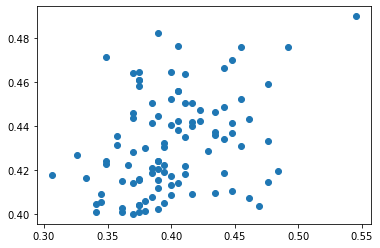

Loss1=8.762257, Loss12=0.001079, ValLoss1=8.805085, ValLoss2=0.017307
Loss1=8.761106, Loss12=0.001081, ValLoss1=8.860348, ValLoss2=0.016667
Loss1=8.750744, Loss12=0.001135, ValLoss1=8.768244, ValLoss2=0.016771
Loss1=8.741534, Loss12=0.001079, ValLoss1=8.795875, ValLoss2=0.016658
Loss1=8.751896, Loss12=0.001110, ValLoss1=8.814296, ValLoss2=0.015206
Loss1=8.750053, Loss12=0.001057, ValLoss1=8.759033, ValLoss2=0.016641
Loss1=8.747751, Loss12=0.001115, ValLoss1=8.869557, ValLoss2=0.016620
Loss1=8.744527, Loss12=0.001124, ValLoss1=8.777454, ValLoss2=0.017213
supervised: finished one epoch (39)!
Loss1=8.763869, Loss12=0.001121, ValLoss1=8.786665, ValLoss2=0.016387
Loss1=8.761797, Loss12=0.001043, ValLoss1=8.823506, ValLoss2=0.016243


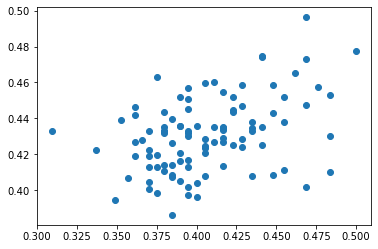

Loss1=8.758343, Loss12=0.001072, ValLoss1=8.814296, ValLoss2=0.016111
Loss1=8.755580, Loss12=0.001058, ValLoss1=8.759033, ValLoss2=0.015921
Loss1=8.753047, Loss12=0.001029, ValLoss1=8.805085, ValLoss2=0.016125
Loss1=8.756501, Loss12=0.001073, ValLoss1=8.777454, ValLoss2=0.016699
Loss1=8.748902, Loss12=0.001081, ValLoss1=8.823506, ValLoss2=0.015703
Loss1=8.759724, Loss12=0.001022, ValLoss1=8.749824, ValLoss2=0.016478
Loss1=8.767093, Loss12=0.001010, ValLoss1=8.786665, ValLoss2=0.016537
Loss1=8.760876, Loss12=0.001060, ValLoss1=8.823506, ValLoss2=0.016615
Loss1=8.758112, Loss12=0.001067, ValLoss1=8.786665, ValLoss2=0.016601
Loss1=8.748672, Loss12=0.001024, ValLoss1=8.841927, ValLoss2=0.015304


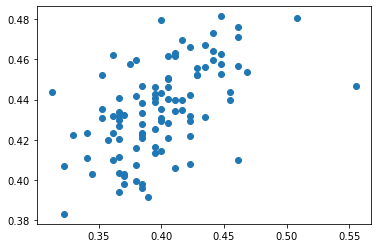

Loss1=8.759494, Loss12=0.001058, ValLoss1=8.878769, ValLoss2=0.016584
Loss1=8.740613, Loss12=0.001100, ValLoss1=8.805085, ValLoss2=0.017018
Loss1=8.760415, Loss12=0.001060, ValLoss1=8.832716, ValLoss2=0.015628
Loss1=8.756961, Loss12=0.001099, ValLoss1=8.814296, ValLoss2=0.015211
supervised: finished one epoch (40)!
Loss1=8.745679, Loss12=0.001031, ValLoss1=8.860348, ValLoss2=0.016743
Loss1=8.750053, Loss12=0.000974, ValLoss1=8.897188, ValLoss2=0.016322
Loss1=8.767093, Loss12=0.001079, ValLoss1=8.759033, ValLoss2=0.015970
Loss1=8.734396, Loss12=0.001005, ValLoss1=8.759033, ValLoss2=0.017047
Loss1=8.760185, Loss12=0.001000, ValLoss1=8.841927, ValLoss2=0.016898
Loss1=8.756501, Loss12=0.001071, ValLoss1=8.823506, ValLoss2=0.017467


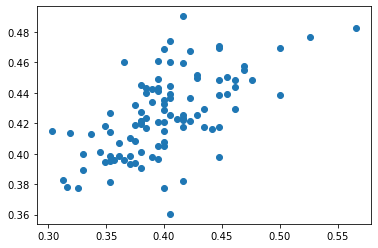

Loss1=8.748672, Loss12=0.001025, ValLoss1=8.759033, ValLoss2=0.016280
Loss1=8.755580, Loss12=0.001030, ValLoss1=8.851137, ValLoss2=0.016799
Loss1=8.745218, Loss12=0.001036, ValLoss1=8.777453, ValLoss2=0.015564
Loss1=8.743837, Loss12=0.001058, ValLoss1=8.860347, ValLoss2=0.014858
Loss1=8.744757, Loss12=0.001016, ValLoss1=8.814296, ValLoss2=0.015841
Loss1=8.751895, Loss12=0.001043, ValLoss1=8.805085, ValLoss2=0.016763
Loss1=8.761106, Loss12=0.001090, ValLoss1=8.832716, ValLoss2=0.016373
Loss1=8.768704, Loss12=0.001101, ValLoss1=8.869557, ValLoss2=0.016383
Loss1=8.764790, Loss12=0.001018, ValLoss1=8.832716, ValLoss2=0.014882
supervised: finished one epoch (41)!
Loss1=8.758803, Loss12=0.001027, ValLoss1=8.832716, ValLoss2=0.016213


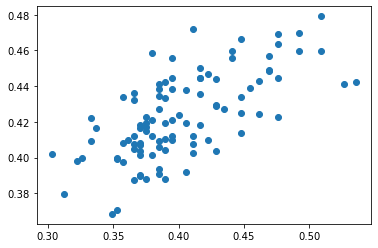

Loss1=8.759955, Loss12=0.001013, ValLoss1=8.823506, ValLoss2=0.016308
Loss1=8.739922, Loss12=0.001000, ValLoss1=8.786664, ValLoss2=0.015728
Loss1=8.759494, Loss12=0.001042, ValLoss1=8.832716, ValLoss2=0.017621
Loss1=8.768704, Loss12=0.001003, ValLoss1=8.869557, ValLoss2=0.014255
Loss1=8.731633, Loss12=0.001015, ValLoss1=8.823506, ValLoss2=0.016066
Loss1=8.747981, Loss12=0.001005, ValLoss1=8.860348, ValLoss2=0.015192
Loss1=8.761336, Loss12=0.000989, ValLoss1=8.832716, ValLoss2=0.015278
Loss1=8.752586, Loss12=0.001015, ValLoss1=8.740613, ValLoss2=0.015866
Loss1=8.761566, Loss12=0.001018, ValLoss1=8.731402, ValLoss2=0.016734
Loss1=8.763408, Loss12=0.001012, ValLoss1=8.795875, ValLoss2=0.016681


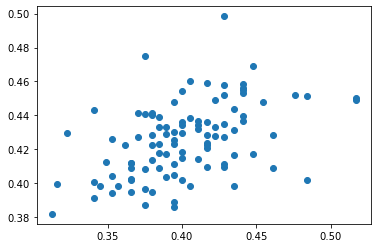

Loss1=8.746139, Loss12=0.001025, ValLoss1=8.722192, ValLoss2=0.015798
Loss1=8.763869, Loss12=0.000990, ValLoss1=8.841926, ValLoss2=0.015194
Loss1=8.764560, Loss12=0.001000, ValLoss1=8.795875, ValLoss2=0.016232
Loss1=8.748902, Loss12=0.001034, ValLoss1=8.841927, ValLoss2=0.015790
Loss1=8.760645, Loss12=0.001021, ValLoss1=8.814296, ValLoss2=0.016519
supervised: finished one epoch (42)!
Loss1=8.763178, Loss12=0.001042, ValLoss1=8.759033, ValLoss2=0.015944
Loss1=8.742915, Loss12=0.000998, ValLoss1=8.786665, ValLoss2=0.015394
Loss1=8.733014, Loss12=0.000994, ValLoss1=8.694561, ValLoss2=0.015774
Loss1=8.739922, Loss12=0.000999, ValLoss1=8.740613, ValLoss2=0.015032
Loss1=8.759033, Loss12=0.001001, ValLoss1=8.786665, ValLoss2=0.015653


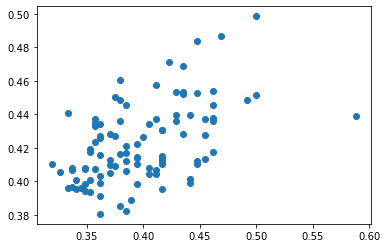

Loss1=8.744757, Loss12=0.000975, ValLoss1=8.832716, ValLoss2=0.016038
Loss1=8.763408, Loss12=0.000971, ValLoss1=8.823506, ValLoss2=0.016048
Loss1=8.756270, Loss12=0.001004, ValLoss1=8.860348, ValLoss2=0.016196
Loss1=8.741534, Loss12=0.000997, ValLoss1=8.759033, ValLoss2=0.015385
Loss1=8.770777, Loss12=0.001002, ValLoss1=8.795875, ValLoss2=0.016567
Loss1=8.778836, Loss12=0.001015, ValLoss1=8.768244, ValLoss2=0.016119
Loss1=8.769856, Loss12=0.000989, ValLoss1=8.860348, ValLoss2=0.017387
Loss1=8.754428, Loss12=0.001023, ValLoss1=8.869558, ValLoss2=0.016445
Loss1=8.762718, Loss12=0.001024, ValLoss1=8.768244, ValLoss2=0.015762
Loss1=8.771237, Loss12=0.001015, ValLoss1=8.712981, ValLoss2=0.015026


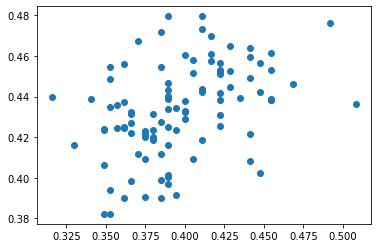

Loss1=8.762718, Loss12=0.000988, ValLoss1=8.749824, ValLoss2=0.015840
supervised: finished one epoch (43)!
Loss1=8.753507, Loss12=0.001053, ValLoss1=8.759033, ValLoss2=0.014782
Loss1=8.763408, Loss12=0.000983, ValLoss1=8.805085, ValLoss2=0.016093
Loss1=8.743146, Loss12=0.000941, ValLoss1=8.786665, ValLoss2=0.015782
Loss1=8.764329, Loss12=0.000955, ValLoss1=8.795875, ValLoss2=0.015147
Loss1=8.761566, Loss12=0.000975, ValLoss1=8.860347, ValLoss2=0.014719
Loss1=8.744067, Loss12=0.001030, ValLoss1=8.786665, ValLoss2=0.015990
Loss1=8.748211, Loss12=0.001025, ValLoss1=8.712982, ValLoss2=0.015582
Loss1=8.757422, Loss12=0.000934, ValLoss1=8.860348, ValLoss2=0.016657
Loss1=8.768704, Loss12=0.001015, ValLoss1=8.795875, ValLoss2=0.016199


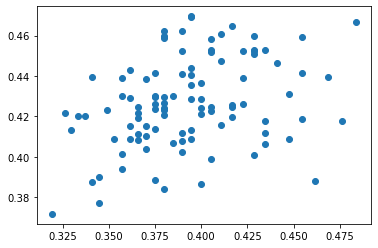

Loss1=8.759494, Loss12=0.000971, ValLoss1=8.768244, ValLoss2=0.017029
Loss1=8.773770, Loss12=0.001013, ValLoss1=8.851137, ValLoss2=0.017460
Loss1=8.761566, Loss12=0.000966, ValLoss1=8.768244, ValLoss2=0.015777
Loss1=8.753507, Loss12=0.000988, ValLoss1=8.841926, ValLoss2=0.016170
Loss1=8.755580, Loss12=0.000984, ValLoss1=8.712981, ValLoss2=0.016022
Loss1=8.743836, Loss12=0.000949, ValLoss1=8.777454, ValLoss2=0.016177
supervised: finished one epoch (44)!
Loss1=8.764329, Loss12=0.000979, ValLoss1=8.786664, ValLoss2=0.016991
Loss1=8.754889, Loss12=0.000942, ValLoss1=8.795875, ValLoss2=0.016949
Loss1=8.757882, Loss12=0.000949, ValLoss1=8.795875, ValLoss2=0.015684
Loss1=8.768474, Loss12=0.000935, ValLoss1=8.795875, ValLoss2=0.016724


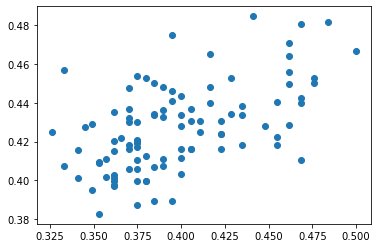

Loss1=8.746600, Loss12=0.001017, ValLoss1=8.731402, ValLoss2=0.016641
Loss1=8.751205, Loss12=0.000972, ValLoss1=8.869557, ValLoss2=0.016774
Loss1=8.741534, Loss12=0.000924, ValLoss1=8.694561, ValLoss2=0.017036
Loss1=8.737619, Loss12=0.000973, ValLoss1=8.851137, ValLoss2=0.016276
Loss1=8.760876, Loss12=0.000956, ValLoss1=8.768244, ValLoss2=0.016560
Loss1=8.765941, Loss12=0.001007, ValLoss1=8.805085, ValLoss2=0.016136
Loss1=8.765711, Loss12=0.001103, ValLoss1=8.768244, ValLoss2=0.017037
Loss1=8.766632, Loss12=0.001008, ValLoss1=8.795875, ValLoss2=0.015713
Loss1=8.752586, Loss12=0.001022, ValLoss1=8.869558, ValLoss2=0.016997
Loss1=8.745678, Loss12=0.001019, ValLoss1=8.805085, ValLoss2=0.017459


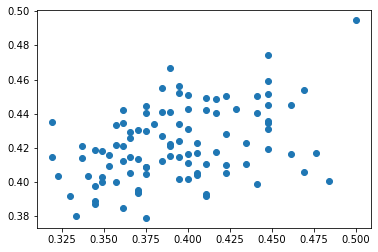

Loss1=8.766402, Loss12=0.001009, ValLoss1=8.740613, ValLoss2=0.016956
Loss1=8.749363, Loss12=0.000953, ValLoss1=8.841926, ValLoss2=0.016985
supervised: finished one epoch (45)!
Loss1=8.771468, Loss12=0.000999, ValLoss1=8.768244, ValLoss2=0.016293
Loss1=8.754428, Loss12=0.001010, ValLoss1=8.805085, ValLoss2=0.017535
Loss1=8.754428, Loss12=0.000967, ValLoss1=8.814296, ValLoss2=0.016964
Loss1=8.721732, Loss12=0.000937, ValLoss1=8.851136, ValLoss2=0.017968
Loss1=8.762487, Loss12=0.000930, ValLoss1=8.731402, ValLoss2=0.016567
Loss1=8.743376, Loss12=0.000947, ValLoss1=8.786665, ValLoss2=0.015695
Loss1=8.748211, Loss12=0.000968, ValLoss1=8.768244, ValLoss2=0.017208
Loss1=8.759955, Loss12=0.000964, ValLoss1=8.777453, ValLoss2=0.015422


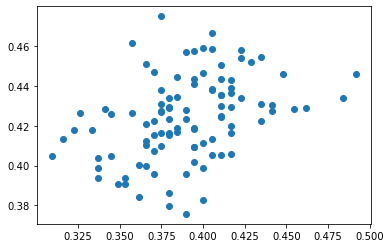

Loss1=8.751435, Loss12=0.000941, ValLoss1=8.749824, ValLoss2=0.016726
Loss1=8.755810, Loss12=0.000983, ValLoss1=8.768244, ValLoss2=0.017610
Loss1=8.740383, Loss12=0.000943, ValLoss1=8.777453, ValLoss2=0.016389
Loss1=8.743376, Loss12=0.000971, ValLoss1=8.869558, ValLoss2=0.017597
Loss1=8.750514, Loss12=0.000966, ValLoss1=8.786665, ValLoss2=0.016849
Loss1=8.765250, Loss12=0.000935, ValLoss1=8.860348, ValLoss2=0.015709
Loss1=8.766862, Loss12=0.000948, ValLoss1=8.768244, ValLoss2=0.015321
Loss1=8.762257, Loss12=0.000963, ValLoss1=8.860348, ValLoss2=0.016838
supervised: finished one epoch (46)!
Loss1=8.750514, Loss12=0.000922, ValLoss1=8.740613, ValLoss2=0.016012
Loss1=8.747521, Loss12=0.000920, ValLoss1=8.823506, ValLoss2=0.015059


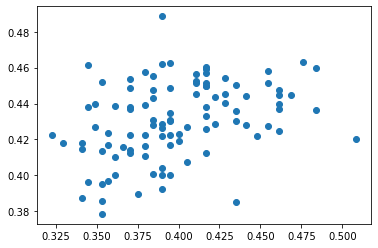

Loss1=8.748902, Loss12=0.000897, ValLoss1=8.777453, ValLoss2=0.016113
Loss1=8.750744, Loss12=0.000877, ValLoss1=8.795875, ValLoss2=0.015502
Loss1=8.752586, Loss12=0.000924, ValLoss1=8.795875, ValLoss2=0.016259
Loss1=8.758343, Loss12=0.000907, ValLoss1=8.823506, ValLoss2=0.015850
Loss1=8.762257, Loss12=0.000909, ValLoss1=8.768244, ValLoss2=0.015492
Loss1=8.759494, Loss12=0.000929, ValLoss1=8.851137, ValLoss2=0.015926
Loss1=8.762948, Loss12=0.000953, ValLoss1=8.768244, ValLoss2=0.015756
Loss1=8.737159, Loss12=0.000965, ValLoss1=8.823506, ValLoss2=0.016648
Loss1=8.749132, Loss12=0.000968, ValLoss1=8.860348, ValLoss2=0.016374
Loss1=8.769625, Loss12=0.000966, ValLoss1=8.841927, ValLoss2=0.015800


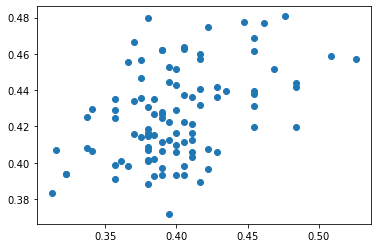

Loss1=8.754659, Loss12=0.000944, ValLoss1=8.814296, ValLoss2=0.015480
Loss1=8.760415, Loss12=0.000944, ValLoss1=8.768244, ValLoss2=0.016328
Loss1=8.762718, Loss12=0.000911, ValLoss1=8.851136, ValLoss2=0.015836
Loss1=8.751435, Loss12=0.000917, ValLoss1=8.768244, ValLoss2=0.016780
supervised: finished one epoch (47)!
Loss1=8.753047, Loss12=0.000908, ValLoss1=8.814296, ValLoss2=0.015556
Loss1=8.743146, Loss12=0.000956, ValLoss1=8.786665, ValLoss2=0.016256
Loss1=8.767323, Loss12=0.000933, ValLoss1=8.841927, ValLoss2=0.016552
Loss1=8.758113, Loss12=0.000874, ValLoss1=8.805085, ValLoss2=0.016853
Loss1=8.748442, Loss12=0.000898, ValLoss1=8.823505, ValLoss2=0.016238
Loss1=8.746139, Loss12=0.000956, ValLoss1=8.786665, ValLoss2=0.016432


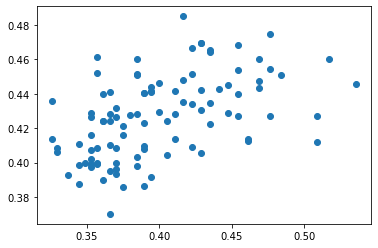

Loss1=8.742685, Loss12=0.000936, ValLoss1=8.722192, ValLoss2=0.016194
Loss1=8.750744, Loss12=0.000927, ValLoss1=8.860348, ValLoss2=0.016244
Loss1=8.775612, Loss12=0.000918, ValLoss1=8.795875, ValLoss2=0.016177
Loss1=8.766172, Loss12=0.000910, ValLoss1=8.777453, ValLoss2=0.017306
Loss1=8.758113, Loss12=0.000922, ValLoss1=8.805085, ValLoss2=0.015751
Loss1=8.741534, Loss12=0.000934, ValLoss1=8.823506, ValLoss2=0.017204
Loss1=8.761106, Loss12=0.000901, ValLoss1=8.777454, ValLoss2=0.017005
Loss1=8.763408, Loss12=0.000914, ValLoss1=8.749824, ValLoss2=0.017200
Loss1=8.740613, Loss12=0.000919, ValLoss1=8.777454, ValLoss2=0.016215
supervised: finished one epoch (48)!
Loss1=8.766632, Loss12=0.000941, ValLoss1=8.878768, ValLoss2=0.015458


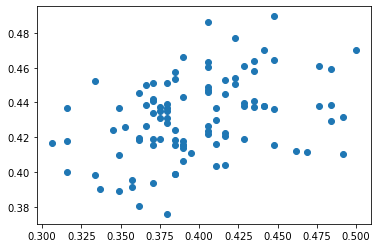

Loss1=8.743146, Loss12=0.000906, ValLoss1=8.805085, ValLoss2=0.017042
Loss1=8.755580, Loss12=0.000920, ValLoss1=8.795875, ValLoss2=0.016792
Loss1=8.762487, Loss12=0.000887, ValLoss1=8.777454, ValLoss2=0.016304
Loss1=8.770316, Loss12=0.000912, ValLoss1=8.768244, ValLoss2=0.015932
Loss1=8.759724, Loss12=0.000865, ValLoss1=8.749824, ValLoss2=0.017292
Loss1=8.762487, Loss12=0.000909, ValLoss1=8.887979, ValLoss2=0.015288
Loss1=8.755580, Loss12=0.000879, ValLoss1=8.878769, ValLoss2=0.017391
Loss1=8.736698, Loss12=0.000944, ValLoss1=8.759033, ValLoss2=0.015954
Loss1=8.752586, Loss12=0.000925, ValLoss1=8.759033, ValLoss2=0.016891
Loss1=8.767093, Loss12=0.000933, ValLoss1=8.731402, ValLoss2=0.015678


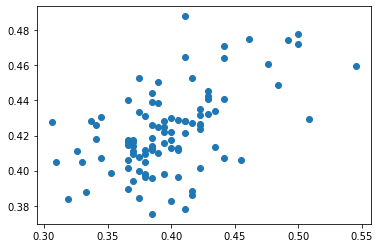

Loss1=8.755119, Loss12=0.000937, ValLoss1=8.749824, ValLoss2=0.015982
Loss1=8.777454, Loss12=0.000909, ValLoss1=8.832717, ValLoss2=0.014530


KeyboardInterrupt: 

In [141]:
from bs_net import *

#net = Net()

train(net, game_rec, iterations=400000, verbose=1);

In [ ]:
# vorhersage auf zufälliger sea
s = newrandomstate()
plot_state(s)
plt.show()
p, v = net(np2t([encode_x(s.sea, s.det)]))
prob = t2np(p)[0,0] * (1-s.det)
plt.imshow(prob)
plt.colorbar()
print(v.item())

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

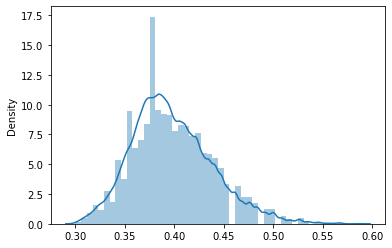

In [7]:
# Verteilung in gamerecords von r
import seaborn as sns
sns.distplot([ r for s, a, r in gamerecords ])

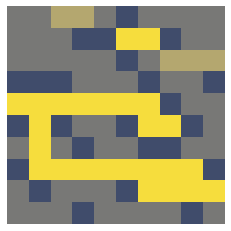

0.4579334557056427 0.46875


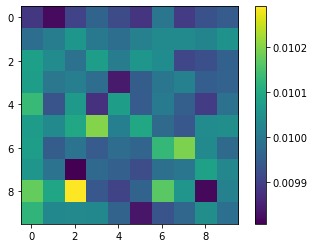

In [92]:
# Vergleich r in gamerecords mit vorhersage des nnet
s, a, r = game_rec[np.random.choice(range(len(game_rec)))]
plot_state(s)
plt.show()
p, v = net(np2t([encode_x(s.sea, s.det)]))
plt.imshow(t2np(p)[0,0])
plt.colorbar()
print(v.item(), r)

In [142]:
inds = np.random.choice(range(len(game_rec)), size=100)
rt = [ game_rec[i][2] for i in inds ]

rp = []
for i in inds:
    s = game_rec[i][0]
    p, v = net(np2t([encode_x(s.sea, s.det)]))
    rp.append(v.item())

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

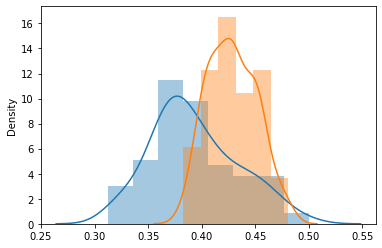

In [144]:
sns.distplot(rt)
sns.distplot(rp)

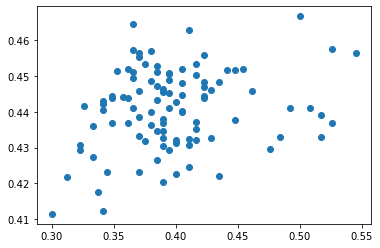

In [135]:
plt.scatter(rt, rp)